# Import libraries and set configs

In [1]:
from typing import Union, Tuple

import sys
sys.path.append("..")

import os
import json
import joblib
import random
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from glob import glob
from optimizer.optimizer import Optimizer
from os import environ
from datetime import timedelta
from tqdm.auto import tqdm
from datetime import datetime

from eli5.sklearn import PermutationImportance

import optuna
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, confusion_matrix, precision_score

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use("fivethirtyeight")

from colorama import Style, Fore

from config.config import ConfigFactory
from indicators import indicators

from api.tvdatafeed.main import TvDatafeed, Interval

from dotenv import load_dotenv, find_dotenv
# here we load environment variables from .env, must be called before init. class
load_dotenv(find_dotenv('../.env'), verbose=True)

# Set environment variable
environ["ENV"] = "optimize"

tv_username = os.getenv("TV_USERNAME")
tv_password = os.getenv("TV_PASSWORD")

class CFG:
    load = False
    historical = False
    create_dataset = False
    update_dataset = False
    cls_target_ratio_tp = 1.03
    cls_target_ratio_sl = 1.03
    ttype = "both"
    patterns_to_filter = ["STOCH_RSI_Volume24"]
    select_features = False
    optimize = False
    optimize_alpha = 0.2
    n_repeats = 1
    n_folds = 8
    min_precision = 0.575
    last_date = datetime.strptime("2024-08-19:12:00:00", "%Y-%m-%d:%H:%M:%S")
    agg_periods = [24, 72]
    agg_funcs = [np.min, np.max, np.mean, np.median, np.std]

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

tqdm.pandas()

warnings.simplefilter(action="ignore", category=(FutureWarning, pd.errors.PerformanceWarning))

# Load data

### Load STOCH_RSI buy data

In [2]:
work_timeframe = "1h"
higher_timeframe = "4h"
opt_limit = 100000

ttype = "buy"
pattern = ["STOCH", "RSI", "Volume24"]
indicator_list = pattern
indicator_list_higher = ["Trend", "MACD"]

# Get configs
configs = ConfigFactory.factory(environ).configs
configs["Indicator_list"] = indicator_list
configs["Higher_TF_indicator_list"] = indicator_list_higher
configs["Timeframes"]["work_timeframe"] = work_timeframe
configs["Timeframes"]["higher_timeframe"] = higher_timeframe

optim_dict = {
                "RSI": {
                        "timeperiod": [14], 
                        "low_bound": [35]
                       },
                "STOCH": {
                          "fastk_period": [9],
                          "slowk_period": [7],
                          "slowd_period": [3], 
                          "low_bound": [25]
                        }
             }

if CFG.load:
  print(f"Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}")
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit="D")
  stat = opt.optimize(pattern, ttype, opt_limit, load=True, op_type="ml", historical=CFG.historical, min_time=min_time)
  display(stat) # 31060

### Load STOCH_RSI sell data

In [3]:
work_timeframe = "1h"
higher_timeframe = "4h"
opt_limit = 100000

ttype = "sell"
pattern = ["STOCH", "RSI", "Volume24"]
indicator_list = pattern
indicator_list_higher = ["Trend", "MACD"]

# Get configs
configs = ConfigFactory.factory(environ).configs
configs["Indicator_list"] = indicator_list
configs["Higher_TF_indicator_list"] = indicator_list_higher
configs["Timeframes"]["work_timeframe"] = work_timeframe
configs["Timeframes"]["higher_timeframe"] = higher_timeframe

optim_dict = {
                "RSI": {
                        "timeperiod": [14], 
                        "low_bound": [35]
                       },
                "STOCH": {
                          "fastk_period": [9],
                          "slowk_period": [7],
                          "slowd_period": [3], 
                          "low_bound": [25]
                        }
             }

if CFG.load:
  print(f"Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}")
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit="D")
  stat = opt.optimize(pattern, ttype, opt_limit, load=False, op_type="ml", historical=CFG.historical, min_time=min_time)
  display(stat) # 23629

# Test loaded data

### Remove dataframe files with the biggest number of missing data

In [4]:
counter = 0 

tickers_1h = glob("../optimizer/ticker_dataframes/*_1h.pkl")
for ticker in tqdm(tickers_1h[3:]):
    df = pd.read_pickle(ticker)
    nunique = df["time"].diff()[1:].nunique()
    if nunique > 1:
        count = df[df["time"].diff().astype("timedelta64[h]") != 1].shape[0]
        if count > 200:
            print(ticker, nunique, count)
            os.remove(ticker)
            os.remove(ticker[:-6] + "4h.pkl")
            
counter

  0%|          | 0/3732 [00:00<?, ?it/s]

0

### Plot time vs index for some of dataframe files

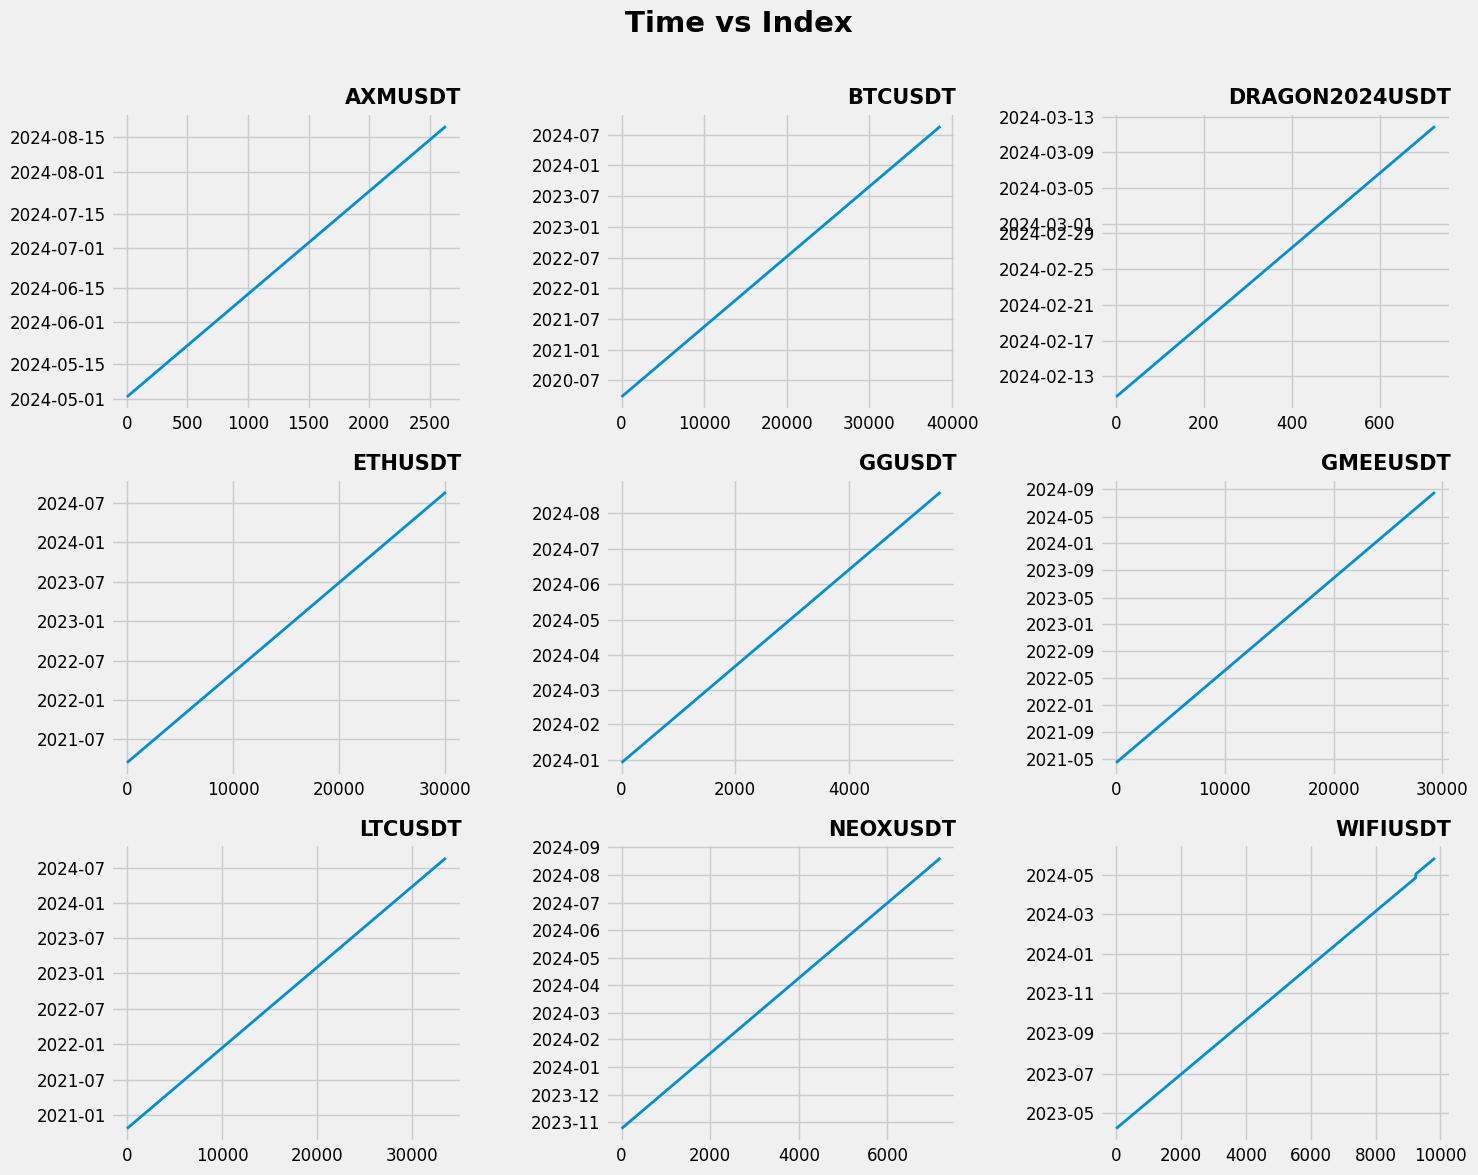

In [5]:
%matplotlib inline

n_cols = 3
n_rows = 3
figsize = (15, 4 * n_rows)

tickers = glob("../optimizer/ticker_dataframes/*_1h.pkl")
random_tickers = random.choices(tickers, k=n_cols*n_rows)
random_tickers[:3] = [t for t in tickers if "/BTCUSDT_1h" in t or "/ETHUSDT_1h" in t or "/LTCUSDT_1h" in t]

def plot_times(random_tickers, n_rows, n_cols):
    fig = plt.figure(figsize=figsize)
    
    for idx in range(n_cols*n_rows):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        
        df = pd.read_pickle(random_tickers[idx])
        sns.lineplot(data=df["time"])

        ax.set_ylabel("")
        plt.yticks(fontsize=12) 
        ax.set_xlabel("")
        plt.xticks(fontsize=12)
        # ax.spines["right"].set_visible(False)
        ax.set_title(f"{random_tickers[idx].split('/')[-1][:-7]}", loc="right", weight="bold", fontsize=15)
        ax.lines[0].set_linewidth(2)

    
    fig.suptitle(f"Time vs Index\n", ha="center",  fontweight="bold", fontsize=21)
    # fig.legend([1, 0], loc="upper center", bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
plot_times(sorted(random_tickers),  n_rows=n_rows, n_cols=n_cols) 

### Check if all dataframe files has data for both timeframes 1h and 4h

In [6]:
import glob

x = glob.glob("../optimizer/ticker_dataframes/*.pkl")
y = [i[31:].split("_")[0] for i in x]
z = ("").join(x)

for i in y:
    if f"{i}_1h" not in z:
        print(i, "1h")
    if f"{i}_4h" not in z:
        print(i, "4h")

SUNDOGUSDT 1h


# Prepare and create train data

### Functions

In [7]:
# Get configs
configs = ConfigFactory.factory(environ).configs

higher_features = ["time", "linear_reg", "linear_reg_angle", "macd", "macdhist", "macdsignal"]
price_cols = ["open","high", "low", "close"]
real_price_cols = ["real_high", "real_low", "real_close"]
funding_cols = ["funding_rate"]
rsi_stoch_cols = ["rsi", "stoch_diff", "stoch_slowd", "stoch_slowk"]
btcd_cols = ["time", "btcd_open", "btcd_high", "btcd_low", "btcd_close", "btcd_volume"]
btcdom_cols = ["time", "btcdom_open", "btcdom_high", "btcdom_low", "btcdom_close", "btcdom_volume"]

def get_file(ticker):
    """ Find files buy ticker names """
    try:
        tmp_df_1h = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_1h.pkl")
        tmp_df_4h = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_4h.pkl")
    except FileNotFoundError:
        return None, None
    else:
        return tmp_df_1h, tmp_df_4h


def add_indicators(df: pd.DataFrame, df_higher: pd.DataFrame, ttype: str, configs: dict) -> pd.DataFrame:
    """Create indicators and add them to the dataset"""
    # add RSI
    rsi = indicators.RSI(ttype, configs)
    df = rsi.get_indicator(df, "", "", 0)
    # add Stochastic
    stoch = indicators.STOCH(ttype, configs)
    df = stoch.get_indicator(df, "", "", 0)
    # add ATR
    atr = indicators.ATR(ttype, configs)
    df = atr.get_indicator(df, "", "", 0)
    # add CCI
    cci = indicators.CCI(ttype, configs)
    df = cci.get_indicator(df, "", "", 0)
    # add SAR
    sar = indicators.SAR(ttype, configs)
    df = sar.get_indicator(df, "", "", 0)
    # add MACD
    macd = indicators.MACD(ttype, configs)
    df_higher = macd.get_indicator(df_higher, "", "", 0)
    # add Trend
    trend = indicators.Trend(ttype, configs)
    df_higher = trend.get_indicator(df_higher, "", "", 0)
    # merge higher timeframe indicators with working timeframe
    df_higher["time"] = df_higher["time"] + pd.to_timedelta(3, unit="h")
    df[higher_features] = pd.merge(df[["time"]], df_higher[higher_features], how="left", on="time")
    df = df.drop(columns=["close_smooth"])
    df = df.drop(columns=[c for c in df.columns if c.endswith("_dir")])
    # merge with BTC.D dataframe
    df[btcd_cols] = pd.merge(df[["time"]], btcd[btcd_cols], how="left", on="time")
    # merge with BTCDOM dataframe
    df[btcdom_cols] = pd.merge(df[["time"]], btcdom[btcdom_cols], how="left", on="time")
    df = df.ffill()
    df[btcdom_cols] = df[btcdom_cols].fillna(df[btcdom_cols].mean().round(1))
    # price and MACD columns to pct difference
    df[real_price_cols] = df[["high", "low", "close"]]
    cols_to_scale = ["open", "high", "low", "close", "macd", "macdhist", "macdsignal", "atr"]
    for c in cols_to_scale:
        df[c] = df[c].pct_change() * 100
    # # add aggregate values
    # for col in ["close", "btcd_close", "btcdom_close"]:
    #     for period in CFG.agg_periods:
    #         for agg_func in CFG.agg_funcs:
    #             df[f"{col}_{agg_func.__name__}_{period}"] = df[col].rolling(period, min_periods=1).agg({"func": agg_func})
    return df.reset_index(drop=True)


def create_train_df(df, ttype, configs, target_offset, first, last, step, train_df_prev=None):
    """ Create train dataset from signal statistics and ticker candle data"""
    train_df = list()
    tickers = df["ticker"].unique()
    
    for ticker in tqdm(tickers):
        
        # get signals with current ticker
        signal_df = df[df["ticker"] == ticker]
        times = signal_df["time"]
        
        # load max time for that ticker from the previously created dataset
        if train_df_prev is not None:
            max_time = train_df_prev.loc[train_df_prev["ticker"] == ticker, "time"].max()
        else:
            max_time = None
        
        # load candle history of this ticker
        tmp_df_1h, tmp_df_4h = get_file(ticker)

        # add indicators 
        try:
            tmp_df_1h = add_indicators(tmp_df_1h, tmp_df_4h, ttype, configs)
        except TypeError:
            # print(f"TypeError, ticker - {ticker}")
            continue

        # add historical data for current ticker
        for i, t in enumerate(times.to_list()):
            if max_time and t <= max_time:
                continue
            
            pass_cycle = False
            pattern = signal_df.iloc[i, signal_df.columns.get_loc("pattern")]
            row = tmp_df_1h.loc[tmp_df_1h["time"] == t, :].reset_index(drop=True)
            
            for i in range(first, last + 1, step):
                # collect features every 4 hours, save difference between the current feature and the lagged features
                time_prev = t + timedelta(hours= -i)
                try:
                    row_tmp = tmp_df_1h.loc[tmp_df_1h["time"] == time_prev, [c for c in tmp_df_1h.columns if c not in real_price_cols]].reset_index(drop=True)
                    if i % 8 != 0:
                        row_tmp = row_tmp.drop(columns=funding_cols)
                    if i % 24 != 0:
                        row_tmp = row_tmp.drop(columns=btcd_cols)
                    row_tmp.columns = [c + f"_prev_{i}" for c in row_tmp.columns]
                except IndexError:
                    pass_cycle = True
                    break
                row = pd.concat([row, row_tmp.iloc[:,1:]], axis=1)
                row["ticker"] = ticker
                row["pattern"] = pattern
                
            if pass_cycle:
                continue

            row["target"] = 0
            row["max_price_deviation"] = 0
            row["ttype"] = ttype
            
            # If ttype = buy and during the selected period high price was higher than close_price * target_ratio
            # and earlier low price wasn't lower than close_price / target_ratio, than target is True, else target is False.
            # Similarly for ttype = sell 
            if pattern.startswith("MACD"):
                close_price = tmp_df_1h.loc[tmp_df_1h["time"] == t + timedelta(hours=3), "real_close"]
            else:
                close_price = tmp_df_1h.loc[tmp_df_1h["time"] == t, "real_close"]

            # move to the next ticker if can't find any data corresponding to time t
            if close_price.shape[0] == 0:
                continue
            
            close_price = close_price.values[0]
            higher_price = close_price * CFG.cls_target_ratio_tp
            lower_price = close_price * (2 - CFG.cls_target_ratio_tp)
            
            target_buys, target_sells = [], []
            for i in range(1, target_offset + 1):
                
                if pattern.startswith("MACD"):
                    time_next = t + timedelta(hours=3+i)
                else:
                    time_next = t + timedelta(hours=i)
                    
                target_buy = tmp_df_1h.loc[tmp_df_1h["time"] == time_next, "real_high"]
                target_sell = tmp_df_1h.loc[tmp_df_1h["time"] == time_next, "real_low"]
                
                target_buys.append(target_buy)
                target_sells.append(target_sell)
                
                if target_buy.shape[0] == 0 or target_sell.shape[0] == 0:
                    if row["target"].values[0] == 0:
                        pass_cycle = True
                    break
                
                target_buy = target_buy.values[0]
                target_sell = target_sell.values[0]

                # set TPs and SLs
                target_buy_tp = 1 if target_buy > higher_price else 0
                target_buy_sl = 1 if target_buy > higher_price else 0
                target_sell_tp = 1 if target_sell < lower_price else 0
                target_sell_sl = 1 if target_sell < lower_price else 0

                pattern = row["pattern"].values[0]
                ttype = row["ttype"].values[0]
                
                # set SL flag and exit cycle if price reaches stop-loss threshold before it reaches take-profit threshold
                # (SL depends on ttype and pattern)
                sl1 = pattern.startswith("STOCH") and ttype == "buy" and target_buy_sl == 1
                sl2 = pattern.startswith("STOCH") and ttype == "sell" and target_sell_sl == 1

                # set TP flag and exit cycle if price reaches take-profit threshold and doesn't reach stop-loss threshold before
                # (TP depends on ttype and pattern)
                tp1 = pattern.startswith("STOCH") and ttype == "buy" and target_sell_tp == 1
                tp2 = pattern.startswith("STOCH") and ttype == "sell" and target_buy_tp == 1
                    
                # if both TP and SL flag is on - don't consider that trade
                if (tp1 and sl1) or (tp2 and sl2):
                    if row["target"].values[0] == 0:
                        pass_cycle = True
                    break
                elif sl1 or sl2:
                    break
                elif tp1 or tp2:
                    row["target"] = 1
                    # break
                
                # if price doesn't reaches both TP and SL thresholds but price above / below enter price for buy / sell trade - set TP flag
                # (depends on ttype and pattern)
                if i == target_offset: 
                    last_price = tmp_df_1h.loc[tmp_df_1h["time"] == time_next, "real_close"].values[0]
                    l1 = pattern.startswith("STOCH") and ttype == "buy" and last_price < close_price
                    l2 = pattern.startswith("STOCH") and ttype == "sell" and last_price > close_price

                    if l1 or l2:
                        row["target"] = 1

                # set the maximum price deviation to the correct side for the current trade period 
                if ttype == "sell":
                    curr_price = (target_buy - close_price) / close_price
                else:
                    curr_price = (close_price - target_sell) / close_price
                
                row["max_price_deviation"] = max(row["max_price_deviation"].values[0], curr_price) 
            
            if pass_cycle:
                continue
            
            if row["max_price_deviation"].values[0] <= 0.02 and row["target"].values[0] == 1:
                max_price_deviation = row["max_price_deviation"].values[0]
                pass
            
            # add data to the dataset
            train_df.append(row)
    
    train_df = pd.concat(train_df).reset_index(drop=True)
    train_df = train_df.drop(columns=real_price_cols)
    return train_df


### Prepare train data

In [8]:
# last previous data point to collect for model training (value represents number of hours before signal point)
last = 272
# for how long time (in hours) we want to predict
target_offset = 96

if CFG.create_dataset:
    # Get BTC dominance
    tv = TvDatafeed(username=tv_username, password=tv_password)
    
    btcd = tv.get_hist("BTC.D","CRYPTOCAP", interval=Interval.in_daily, n_bars=7000, extended_session=True).reset_index()
    btcd = btcd.drop(columns="symbol")
    btcd.columns = btcd_cols
    btcd["time"] = btcd["time"] + pd.to_timedelta(23, unit="h")

    btcdom = tv.get_hist("BTCDOMUSDT.P","BINANCE", interval=Interval.in_4_hour, n_bars=7000, extended_session=True).reset_index()
    btcdom = btcdom.drop(columns="symbol")
    btcdom.columns = btcdom_cols
    btcdom["time"] = btcdom["time"] + pd.to_timedelta(3, unit="h")
    
    # first previous data point to collect for model training (value represents number of hours before signal point)
    first = 4
    # step of previous data points collecting (total number of points to collect is (last - first + step) / step)
    step = 4

    # Buy
    # good hours: 
    # dataset with the signal statistics
    df = pd.read_pickle("signal_stat/buy_stat_1h.pkl")
    df = df[df["time"].dt.year > 1970]
    df = df[df["pattern"].isin(CFG.patterns_to_filter)]
    buy_hours_to_save = [0, 1, 2, 3, 4, 15, 16, 17, 18, 19, 22, 23]
    df = df[df["time"].dt.hour.isin(buy_hours_to_save)]
    # if previously generated dataset exists - update it, don't create it from scratch
    train_df_prev = None
    if CFG.update_dataset:
        try:
            train_df_prev = pd.read_pickle(f"signal_stat/train_buy_{last}.pkl")
        except FileNotFoundError:
            pass
    # dataset for model training
    train_buy = create_train_df(df, "buy", configs, target_offset, first, last, step, train_df_prev)
    train_buy = train_buy.dropna()
    if CFG.update_dataset and train_df_prev is not None:
        train_buy = pd.concat([train_df_prev, train_buy]).reset_index(drop=True)
    train_buy.to_pickle(f"signal_stat/train_buy_{last}.pkl")

    display(train_buy.head())
    display(train_buy.shape)

    # Sell
    # good hours 
    # dataset with the signal statistics
    df = pd.read_pickle("signal_stat/sell_stat_1h.pkl")
    df = df[df["time"].dt.year > 1970]
    df = df[df["pattern"].isin(CFG.patterns_to_filter)]
    sell_hours_to_save = [9, 14, 17, 23]
    df = df[df["time"].dt.hour.isin(sell_hours_to_save)]
    # if previously generated dataset exists - update it, don't create it from scratch
    train_df_prev = None
    if CFG.update_dataset:
        try:
            train_df_prev = pd.read_pickle(f"signal_stat/train_sell_{last}.pkl")
        except FileNotFoundError:
            pass
    # dataset for model training
    train_sell = create_train_df(df, "sell", configs, target_offset, first, last, step, train_df_prev)
    train_sell = train_sell.dropna()
    if CFG.update_dataset and train_df_prev is not None:
        train_sell = pd.concat([train_df_prev, train_sell]).reset_index(drop=True)
    train_sell.to_pickle(f"signal_stat/train_sell_{last}.pkl")

    display(train_sell.head())
    display(train_sell.shape)
    
    # this is made for tests
    df = pd.read_pickle("signal_stat/buy_stat_1h.pkl")
    df = df[df["time"].dt.year > 1970]
    df = df[df["pattern"].isin(CFG.patterns_to_filter)]

    test_df_buy_1 = df[df["time"].dt.hour.isin(buy_hours_to_save[0:1])]
    test_df_buy_1 = create_train_df(test_df_buy_1, "buy", configs, target_offset, first, last, step)
    test_df_buy_1 = test_df_buy_1.dropna().sort_values("time").reset_index(drop=True)

    df = pd.read_pickle("signal_stat/sell_stat_1h.pkl")
    df = df[df["time"].dt.year > 1970]
    df = df[df["pattern"].isin(CFG.patterns_to_filter)]
    
    test_df_sell_1 = df[df["time"].dt.hour.isin(sell_hours_to_save[0:1])]
    test_df_sell_1 = create_train_df(test_df_sell_1, "sell", configs, target_offset, first, last, step)
    test_df_sell_1 = test_df_sell_1.dropna().sort_values("time").reset_index(drop=True)

    del df

### Create train dataset

In [9]:
train_buy = pd.read_pickle(f"signal_stat/train_buy_{last}.pkl")
train_sell = pd.read_pickle(f"signal_stat/train_sell_{last}.pkl")

train_df = pd.concat([train_buy, train_sell])
train_df = train_df.sort_values("time")

# do not consider the last signals - they may contain erroneus signals
train_df = train_df[train_df["time"] < train_df["time"].max()].reset_index(drop=True)

macd_cols = [c for c in train_df.columns if "prev" not in c and "sar" in c]

# Data tests

### Test train dataframe columns

In [10]:
import re

if CFG.create_dataset:
    # check if train dataset has only columns that we expect
    cols = set(re.sub(r"_prev_\d+", "", c) for c in train_buy.columns)

    agg_funcs = ["amin", "amax", "mean", "median", "std"]
    agg_cols = [c for c in cols if len(c.split("_")) > 2 and c.split("_")[-2] in agg_funcs]

    expected_cols = set(price_cols + higher_features + funding_cols + rsi_stoch_cols +
                        btcd_cols + btcdom_cols + agg_cols + ["atr", "cci", "sar", "volume", "pattern", "target", "max_price_deviation", "ticker", "ttype"])
    assert expected_cols == cols

    # check RSI and STOCH columns, their values must be in [0, 100] range 
    rsi_stoch_cols_ = [c for c in train_df.columns if ("rsi" in c or "stoch" in c) and "diff" not in c]
    for r_s_c in rsi_stoch_cols_:
        assert train_df[r_s_c].min() > -0.0001
        assert train_df[r_s_c].max() < 100.0001

    # check volume columns, their values must be >= 0
    vol_cols_ = [c for c in train_df.columns if "volume" in c]
    for v_c in vol_cols_:
        assert train_df[v_c].min() >= 0

    # check funding columns, their period must be 8 hours
    funding_cols_ = [c for c in train_df.columns if c.startswith("funding")]
    for f_c in funding_cols_:
        num = "".join([i for i in f_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 8 == 0

    # check BTC dominance columns, their values must be in [0, 100] range 
    # and their period must be 24 hours
    btcd_cols_ = [c for c in train_df.columns if c.startswith("btcd_") and "volume" not in c]
    for b_c in btcd_cols_:
        pass_cycle = False
        for a_c in agg_funcs:
            if a_c in b_c:
                pass_cycle = True
                break
        if pass_cycle:
            continue
        # check values
        assert train_df[b_c].min() >= 0
        assert train_df[b_c].max() <= 100
        # check period
        num = "".join([i for i in b_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 24 == 0

    # check the rest columns, their period must be 4 hours
    rest_cols_ = [c for c in train_df.columns if c not in funding_cols_ and c not in btcd_cols]
    for r_c in rest_cols_:
        num = "".join([i for i in r_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 4 == 0

    # check if changing of source dataframe doesn't affect the resulting train dataframe
    test_df_buy_2 = train_buy[train_buy["time"].dt.hour.isin(buy_hours_to_save[0:1])]
    assert test_df_buy_1.shape == test_df_buy_2.shape
    test_df_sell_2 = train_sell[train_sell["time"].dt.hour.isin(sell_hours_to_save[0:1])]
    assert test_df_sell_1.shape == test_df_sell_2.shape

    # plot time values 
    train_df["time"].plot(title="Signal Time distribution")


### Test buy target corectness

In [11]:
prev_ticker = None

train_buy_ = train_buy[train_buy["ticker"] == "MILOUSDT"]

if CFG.create_dataset:
    for i in tqdm(range(train_buy.shape[0])):
        x = train_buy[["ticker", "ttype", "pattern", "time", "close", "target"]]
        y = x.iloc[i]
        pattern, ticker, time_, target = y["pattern"], y["ticker"], y["time"], y["target"]
        if ticker != "MILOUSDT":
            continue

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_1h.pkl")
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h["time"] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h["time"] == time_, "close"].values[0]
        last_idx = min(idx+target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc("close")]
        low_price = close_price * (2 - CFG.cls_target_ratio_tp)
        high_price = close_price * CFG.cls_target_ratio_tp
        tmp_df_1h["low_price"] = low_price
        tmp_df_1h["high_price"] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+target_offset+1][["time", "close", "high", "high_price", "low", "low_price"]]
        tmp_df_1h["signal"] = tmp_df_1h["low"] < tmp_df_1h["low_price"]
        tmp_df_1h["anti_signal"] = tmp_df_1h["high"] > tmp_df_1h["high_price"]
        
        first_signal = tmp_df_1h["signal"].argmax()
        first_anti_signal = tmp_df_1h["anti_signal"].argmax()
        
        if tmp_df_1h["signal"].max() == 0 and tmp_df_1h["anti_signal"].max() == 0:
            if pattern.startswith("STOCH"): 
                if last_price < close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h["signal"].max() == 0:
            assert target == 0
        elif tmp_df_1h["anti_signal"].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                try:
                    assert first_signal > first_anti_signal
                except AssertionError:
                    pass

### Test sell target corectness

In [12]:
if CFG.create_dataset:
    for i in tqdm(range(train_sell.shape[0])):
        x = train_sell[["ticker", "ttype", "pattern", "time", "close", "target"]]
        y = x.iloc[i]
        pattern, ticker, time_, target = y["pattern"], y["ticker"], y["time"], y["target"]

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_1h.pkl")
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h["time"] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h["time"] == time_, "close"].values[0]
        last_idx = min(idx+target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc("close")]
        low_price = close_price * (2 - CFG.cls_target_ratio_tp)
        high_price = close_price * CFG.cls_target_ratio_tp
        tmp_df_1h["low_price"] = low_price
        tmp_df_1h["high_price"] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+target_offset+1][["time", "close", "high", "high_price", "low", "low_price"]]
        tmp_df_1h["signal"] = tmp_df_1h["high"] > tmp_df_1h["high_price"]
        tmp_df_1h["anti_signal"] = tmp_df_1h["low"] < tmp_df_1h["low_price"]

        first_signal = tmp_df_1h["signal"].argmax()
        first_anti_signal = tmp_df_1h["anti_signal"].argmax()
        
        if tmp_df_1h["signal"].max() == 0 and tmp_df_1h["anti_signal"].max() == 0:
            if pattern.startswith("STOCH"):
                if last_price > close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h["signal"].max() == 0:
            assert target == 0
        elif tmp_df_1h["anti_signal"].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                assert first_signal > first_anti_signal

### Test pattern / target distribution

In [13]:
def q10(x):
    return x.quantile(0.1)

def q30(x):
    return x.quantile(0.3)

def q90(x):
    return x.quantile(0.9)

def trust_interval(row, z=1.95):
    """ Calculate trust interval for Bernulli distribution """
    sum, val1 = row["total"], row["count"]
    val2 = sum - val1
    n = val1 + val2
    p = val1 / n
    low_bound = p - z * np.sqrt(p * (1-p) / n)
    high_bound = p + z * np.sqrt(p * (1-p) / n)
    return round(low_bound, 4), round(high_bound, 4)

pvt = train_buy[(train_buy["time"] < CFG.last_date)]
pvt = pvt[["target", "pattern", "time", "max_price_deviation"]]
pvt["hour"] = pvt["time"].dt.hour
pvt = pvt.pivot_table(index=["hour", "target"], 
                      values=["pattern", "max_price_deviation"], 
                      aggfunc={
                          "pattern": "count",
                          "max_price_deviation": ["median", q10, q30, q90],
                          }).reset_index()
pvt.columns = ["hour", "target", "max_price_dev_q50", 
               "max_price_dev_q10", "max_price_dev_q30", 
               "max_price_dev_q90", "pattern"]
pvt["total"] = pvt.groupby("hour")["pattern"].transform("sum")
pvt = pvt.rename(columns={"pattern": "count"})
pvt["pct"] = pvt["count"] / pvt["total"]
pvt = pvt[pvt["target"]==1]
pvt["trust_interval"] = pvt.apply(trust_interval, axis=1)

print("Buy")
display(pvt)
display(train_buy["ttype"].value_counts())
display(train_buy[["target", "pattern"]].value_counts())
display(train_buy[["target", "pattern"]].value_counts(normalize=True))

pvt = train_sell[(train_sell["time"] < CFG.last_date)]
pvt = pvt[["target", "pattern", "time", "max_price_deviation"]]
pvt["hour"] = pvt["time"].dt.hour
pvt = pvt.pivot_table(index=["hour", "target"], 
                      values=["pattern", "max_price_deviation"], 
                      aggfunc={
                          "pattern": "count",
                          "max_price_deviation": ["median", q10, q30, q90],
                          }).reset_index()
pvt.columns = ["hour", "target", "max_price_dev_q50", 
               "max_price_dev_q10", "max_price_dev_q30", 
               "max_price_dev_q90", "pattern"]
pvt["total"] = pvt.groupby("hour")["pattern"].transform("sum")
pvt = pvt.rename(columns={"pattern": "count"})
pvt["pct"] = pvt["count"] / pvt["total"]
pvt = pvt[pvt["target"]==1]
pvt["trust_interval"] = pvt.apply(trust_interval, axis=1)

print("Sell")
display(pvt)
display(train_sell["ttype"].value_counts())
display(train_sell[["target", "pattern"]].value_counts())
display(train_sell[["target", "pattern"]].value_counts(normalize=True))

Buy


,hour,target,max_price_dev_q50,max_price_dev_q10,max_price_dev_q30,max_price_dev_q90,count,total,pct,trust_interval
1,0,1,0.077040,0.035691,0.052569,0.256466,1268,2191,0.578731,"(0.5582, 0.5993)"
3,1,1,0.074571,0.035879,0.050682,0.233607,1381,2533,0.545203,"(0.5259, 0.5645)"
5,2,1,0.078155,0.035062,0.051167,0.249291,1451,2690,0.539405,"(0.5207, 0.5581)"
7,3,1,0.084813,0.036167,0.056653,0.266522,1659,3023,0.548793,"(0.5311, 0.5664)"
9,4,1,0.081329,0.036231,0.053729,0.256488,1495,2912,0.513393,"(0.4953, 0.5315)"
11,15,1,0.091821,0.035933,0.056080,0.235905,1187,2237,0.530621,"(0.51, 0.5512)"
13,16,1,0.093103,0.036767,0.056723,0.247552,1073,2030,0.528571,"(0.507, 0.5502)"
15,17,1,0.085345,0.036059,0.057514,0.235242,1138,2038,0.558391,"(0.5369, 0.5798)"
17,18,1,0.090582,0.036145,0.056788,0.234928,1073,1952,0.549693,"(0.5277, 0.5717)"
19,19,1,0.085955,0.036321,0.055927,0.228890,992,1873,0.529632,"(0.5071, 0.5521)"


buy    27520
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    14951
0       STOCH_RSI_Volume24    12569
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.543278
0       STOCH_RSI_Volume24    0.456722
dtype: float64

Sell


,hour,target,max_price_dev_q50,max_price_dev_q10,max_price_dev_q30,max_price_dev_q90,count,total,pct,trust_interval
1,9,1,0.083629,0.036189,0.057113,0.275263,919,1733,0.530294,"(0.5069, 0.5537)"
3,14,1,0.078906,0.036717,0.052954,0.255016,936,1769,0.529112,"(0.506, 0.5523)"
5,17,1,0.078112,0.035200,0.054325,0.304622,651,1224,0.531863,"(0.5041, 0.5597)"
7,23,1,0.080576,0.034544,0.051266,0.296739,679,1271,0.534225,"(0.5069, 0.5615)"


sell    5997
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    3185
0       STOCH_RSI_Volume24    2812
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.531099
0       STOCH_RSI_Volume24    0.468901
dtype: float64

# Data visualization

### Plot ratio of class 1 for every week day

Monday = 0, Sunday = 6

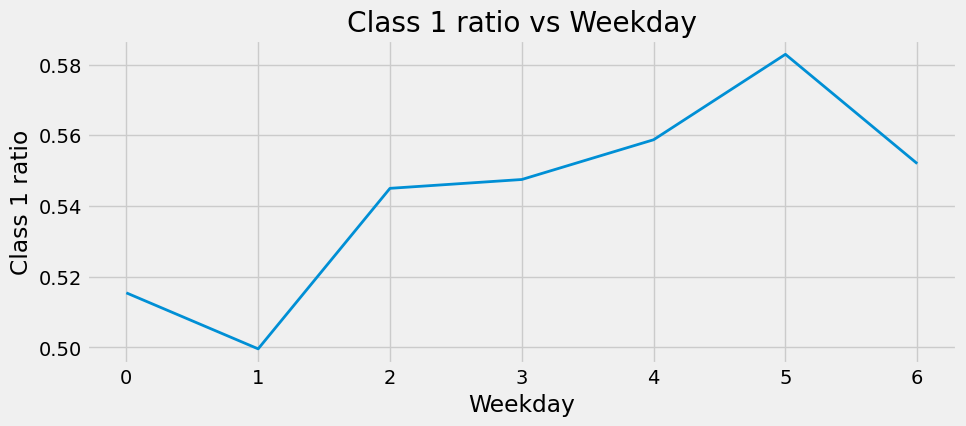

In [14]:
plt.figure(figsize=(10, 4))

group_df = train_df[(train_df["time"].dt.year >= 2020)]
group_df["weekday"] = group_df["time"].dt.weekday
ax = group_df.groupby("weekday")["target"].mean().plot()
ax.lines[0].set_linewidth(2)
ax.set_xlabel("Weekday")
ax.set_ylabel("Class 1 ratio")
ax.set_title("Class 1 ratio vs Weekday");

### Plot ratio of class 1 for every month

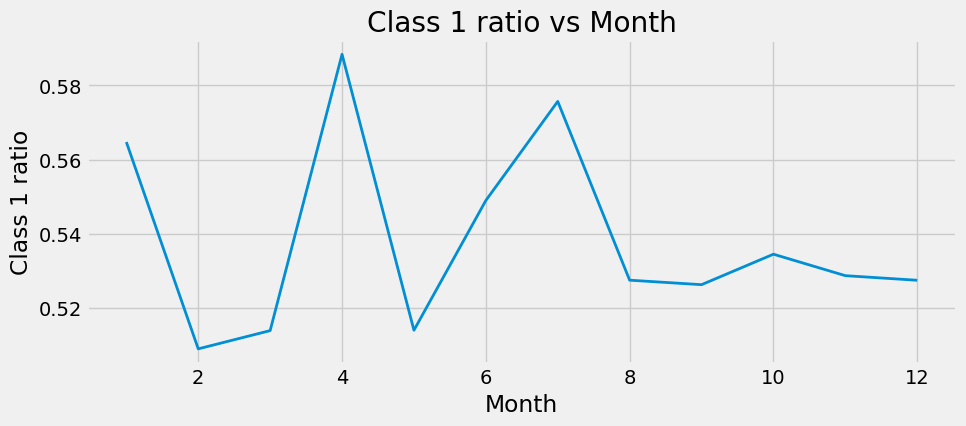

In [15]:
plt.figure(figsize=(10, 4))

group_df = train_df[(train_df["time"].dt.year >= 2020)]
group_df["month"] = group_df["time"].dt.month
ax = group_df.groupby("month")["target"].mean().plot()
ax.lines[0].set_linewidth(2)
ax.set_xlabel("Month")
ax.set_ylabel("Class 1 ratio")
ax.set_title("Class 1 ratio vs Month");

### Plot ratio of class 1 for every day of last months

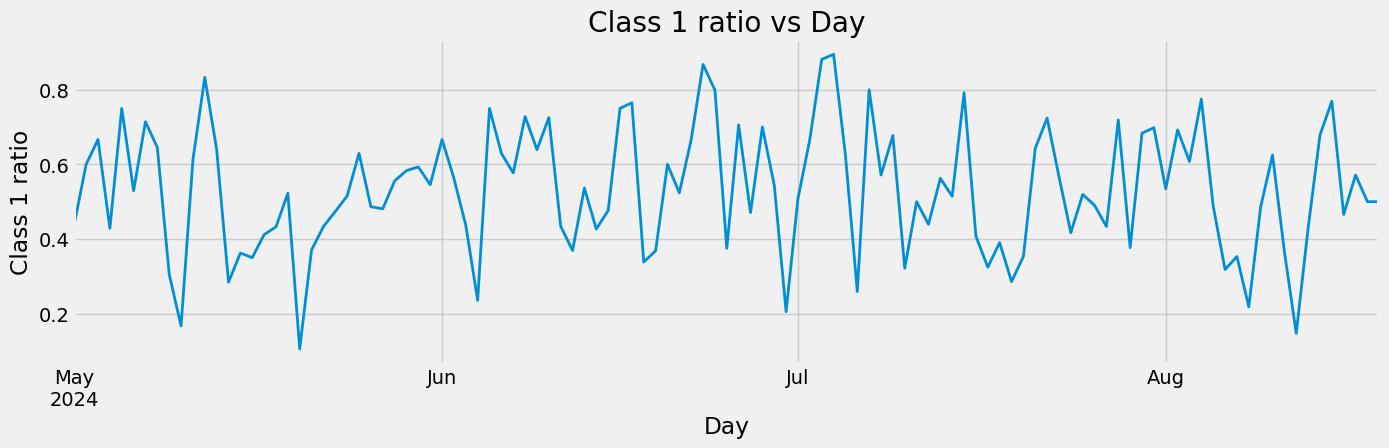

In [16]:
plt.figure(figsize=(15, 4))

group_df = train_df[(train_df["time"].dt.year >= 2024) & (train_df["time"].dt.month >= 5)]
group_df["day"] = group_df["time"].dt.to_period("D")
ax = group_df.groupby("day")["target"].mean().plot()
ax.lines[0].set_linewidth(2)
ax.set_xlabel("Day")
ax.set_ylabel("Class 1 ratio")
ax.set_title("Class 1 ratio vs Day");

### Visualize buy trades

In [17]:
import matplotlib.pyplot as plt
import mplfinance as mpf

if CFG.create_dataset:

    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_buy.index
    test_buy = train_buy.sample(plt_num, axis=0)


    for i, row in test_buy.iterrows():
        ticker = row["ticker"]
        time = row["time"]
        target = row["target"]
        ttype = row["ttype"]
        pattern = row["pattern"]

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h["time"] >= time) & (df_1h["time"] <= time + timedelta(hours=target_offset))]

        ohlc = df_1h[["time", "open", "high", "low", "close", "volume"]].set_index("time")
        
        price = df_1h.iloc[0]["close"]
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type="candle", warn_too_much_data=1001, style="yahoo", ylabel="", tz_localize=True, ax=ax)
        
        if ttype == "buy":
            ax.axhline(high_price, color="g")
            ax.axhline(low_price, color="r")
        else:
            ax.axhline(high_price, color="r")
            ax.axhline(low_price, color="g")
        ax.set_title(f"Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}", fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize sell trades

In [18]:
if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_sell.index
    test_sell = train_sell.sample(plt_num, axis=0)

    for i, row in test_sell.iterrows():
        ticker = row["ticker"]
        time = row["time"]
        target = row["target"]
        ttype = row["ttype"]
        pattern = row["pattern"]

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h["time"] >= time) & (df_1h["time"] <= time + timedelta(hours=target_offset))]
        
        ohlc = df_1h[["time", "open", "high", "low", "close", "volume"]].set_index("time")
        
        price = df_1h.iloc[0]["close"]
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type="candle", warn_too_much_data=1001, style="yahoo", ylabel="", tz_localize=True, ax=ax)
        
        if ttype == "buy":
            ax.axhline(high_price, color="g")
            ax.axhline(low_price, color="r")
        else:
            ax.axhline(high_price, color="r")
            ax.axhline(low_price, color="g")
        ax.set_title(f"Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}", fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize feature distributions

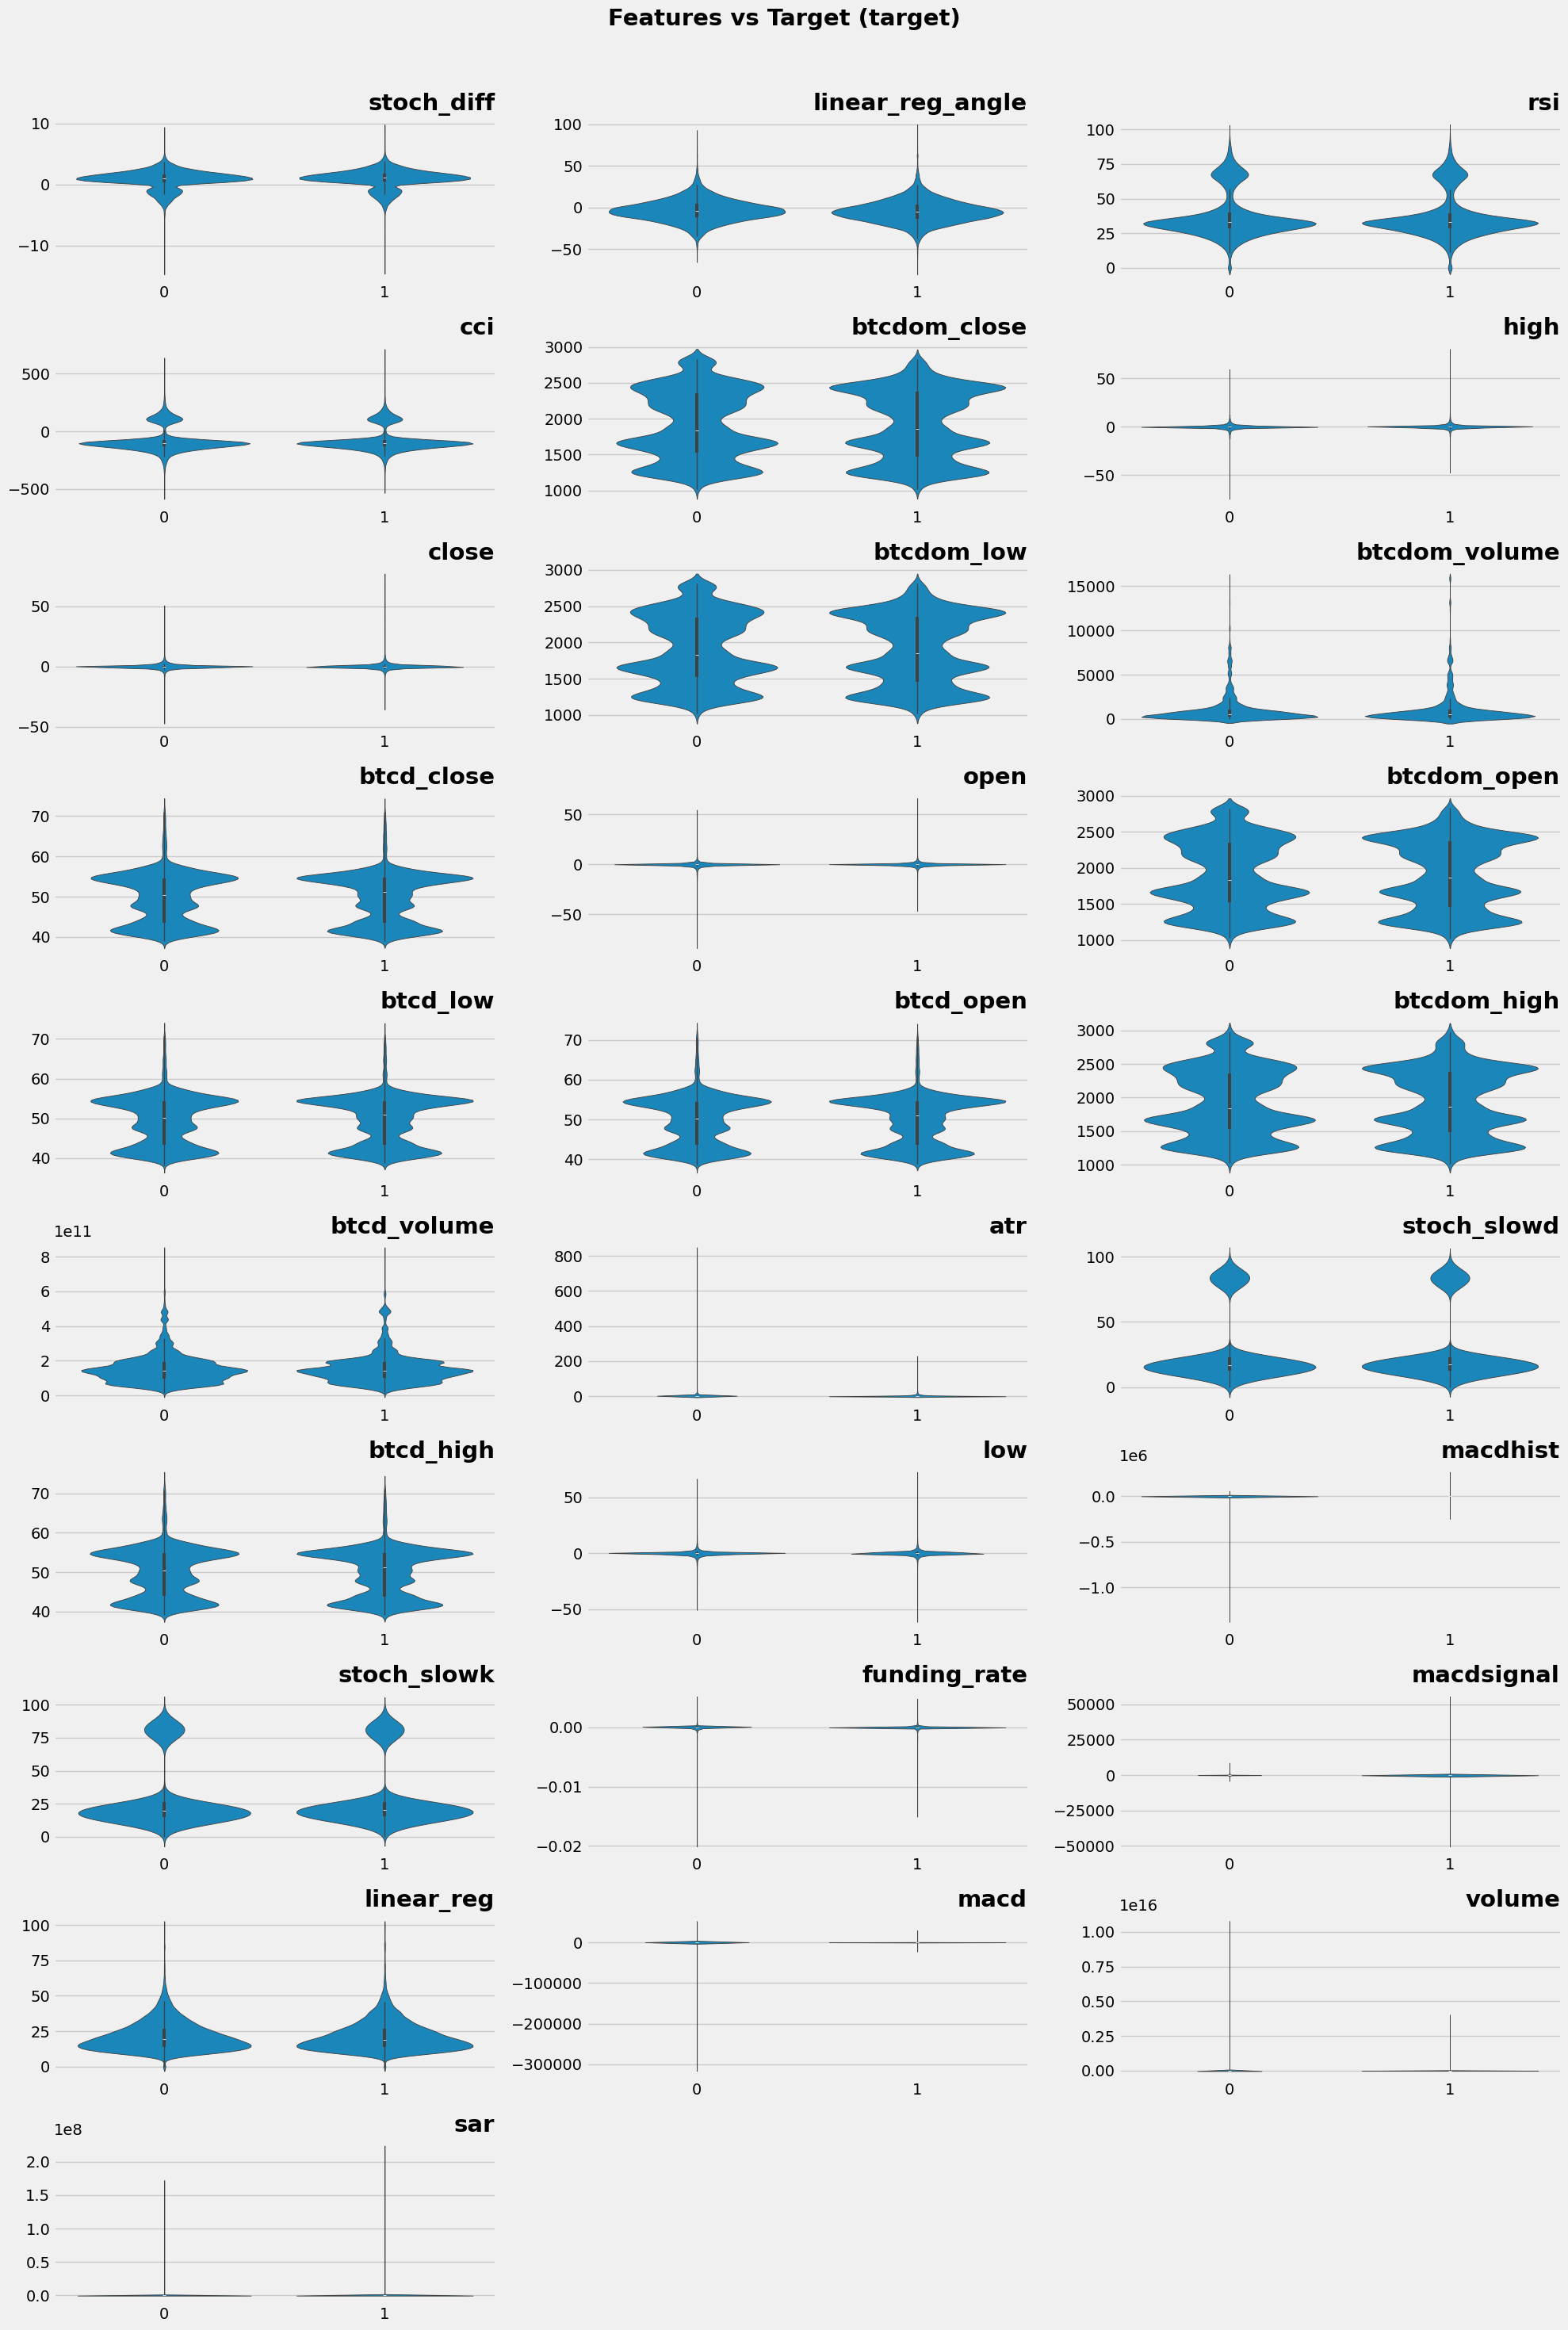

In [19]:
fi = pd.read_csv(f"model/feature_importance.csv")["Feature"].to_list()
cols = [c for c in fi if "prev" not in c]
figsize = (20, 30)

def plot_target_violine(df, df_cols, n_rows, n_cols, target):
    fig = plt.figure(figsize=figsize)
    
    for idx, col in enumerate(df_cols):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        try:
            sns.violinplot(x=target, y=col, data=df)
        except ValueError:
            print(f"Can't find {col} in the dataframe")

        ax.set_ylabel(""); ax.spines["top"].set_visible(False), 
        ax.set_xlabel(""); ax.spines["right"].set_visible(False)
        ax.set_title(f"{col}", loc="right", weight="bold", fontsize=21)

    
    fig.suptitle(f"Features vs Target ({target})\n\n\n", ha="center",  fontweight="bold", fontsize=21)
    # fig.legend([1, 0], loc="upper center", bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
n_cols = 3
n_rows = len(cols) // n_cols + 1
plot_target_violine(train_df, cols, n_rows=n_rows, n_cols=n_cols, target="target")

### Show the last signals

In [20]:
x = pd.read_pickle("signal_stat/buy_stat_1h.pkl")
x["ttype"] = "buy"
y = pd.read_pickle("signal_stat/sell_stat_1h.pkl")
y["ttype"] = "sell"
x = pd.concat([x, y]).sort_values("time").reset_index(drop=True)
x.loc[x["pattern"] == "STOCH_RSI_Volume24", ["time", "ticker", "ttype", "pattern"]].tail(50
                                                                                        )

,time,ticker,ttype,pattern
114588,2024-08-19 00:00:00,NKNUSDT,sell,STOCH_RSI_Volume24
114589,2024-08-19 01:00:00,PUSHUSDT,sell,STOCH_RSI_Volume24
114590,2024-08-19 01:00:00,ATMUSDT,sell,STOCH_RSI_Volume24
114591,2024-08-19 01:00:00,OAXUSDT,sell,STOCH_RSI_Volume24
114592,2024-08-19 01:00:00,PEPEIUSDT,buy,STOCH_RSI_Volume24
114593,2024-08-19 01:00:00,SVLUSDT,sell,STOCH_RSI_Volume24
114594,2024-08-19 01:00:00,ONEUSDT,sell,STOCH_RSI_Volume24
114595,2024-08-19 01:00:00,JUVUSDT,sell,STOCH_RSI_Volume24
114596,2024-08-19 01:00:00,VELOUSDT,buy,STOCH_RSI_Volume24
114597,2024-08-19 01:00:00,ARIXUSDT,buy,STOCH_RSI_Volume24


# Feature selection

### Select features with BORUTA feature importance

In [21]:
from shaphypetune import BoostBoruta
  
params = {
          "boosting_type": "dart",
          "n_estimators": 1000,
          "learning_rate": 0.02,
          "max_depth": 10,
          "subsample" : 0.7,
          "colsample_bytree": 0.85,
          "num_leaves": 24,
          "verbosity": -1,
          "importance_type": "gain",
          "max_bin": 255,
          "reg_alpha": 1e-6,
          "reg_lambda": 1e-7,
          "objective": "binary",
          "metric": "auc"
        }
features = [c for c in train_df.columns if c not in ["time", "target", "ticker", "pattern", "ttype", "max_price_deviation"]]


def ppv_npv_acc(y_true, y_pred):
    """ Calculate confusion matrix and return harmonic mean score of Positive Predictive Value (PPV, precisoin) and Negative Predictive Value (NPV) """
    try:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    except ValueError:
        return 0
    return (tp + tn) / (tp + fp + tn + fn + 1e-8)

def ppv_npv_acc_lgbm(y_true, y_pred):
    """ Metric for LGBM """
    return "ppv_npv_acc", ppv_npv_acc(y_true, y_pred), False


def boruta_selction(df):
    boruta_df_ = pd.DataFrame()

    X, y, time = df[features], df["target"], df["time"]

    tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
    eval_metric = "logloss"

    # Stratify based on Class and Alpha (3 types of conditions)
    for fold, (train_idx, val_idx) in enumerate(tss.split(time)):

        print(f"Fold: {fold}")
        # Split the dataset according to the fold indexes.
        X_train = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        clf = lgb.LGBMClassifier(**params)
        model = BoostBoruta(clf, importance_type="shap_importances", train_importance=False, max_iter=1000)
        try:
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                      eval_metric="logloss", 
                      callbacks=[lgb.log_evaluation(100)])
        except RuntimeError:
            break

        boruta_importance_df = pd.DataFrame({"importance": model.ranking_}, index=X_train.columns).sort_index()
        if boruta_df_.shape[0] == 0:
            boruta_df_ = boruta_importance_df.copy()
        else:
            boruta_df_ += boruta_importance_df

    boruta_df_ = boruta_df_.sort_values("importance")
    boruta_df_ = boruta_df_.reset_index().rename({"index": "Feature"}, axis=1)

    return boruta_df_


if CFG.select_features:
    boruta_df_ = boruta_selction(train_df)

### Select features with permutation importance and GBM feature importance

In [22]:
palette = ["#302c36", "#037d97", "#E4591E", "#C09741",
           "#EC5B6D", "#90A6B1", "#6ca957", "#D8E3E2"]

blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

# load the list of Bybit tickers
with open(f"model/bybit_tickers.json", "r") as f:
    bybit_tickers = json.load(f)

def lgbm_tuning(df, permut=False):
    outer_cv_score = [] # store all cv scores of outer loop inference

    perm_df_ = pd.DataFrame()
    feature_importances_ = pd.DataFrame()

    X, y, time = df[features], df["target"], df["time"]
    
    for fold in range(CFG.n_repeats):
        print(f"Repeat {blu}#{fold+1}")

        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
        
        oof = np.zeros(len(df))
        
        # Stratify based on Class and Alpha (3 types of conditions)
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            if fold == 0:
                first_val_idx = val_idx[0]
            
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_train_time = time[fit_idx].max() + pd.to_timedelta(96, unit="h")
            max_val_time = time[val_idx].max()
            # also select only tickers from ByBit for validation because we trade on ByBit only
            val_idx = time[(time > max_train_time) & (time <= max_val_time) & (train_df["ticker"].isin(bybit_tickers))].index.tolist()
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            clf = lgb.LGBMClassifier(**params)
            clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                    eval_metric="logloss", 
                    callbacks=[lgb.log_evaluation(100)])

            val_preds = clf.predict_proba(X_val)[:,1]
            val_score = log_loss(y_val, val_preds)
            
            oof[val_idx] = val_preds
            best_iter = clf.best_iteration_

            print(f"Fold: {blu}{fold + 1:>3}{res}| loss: {blu}{val_score:.5f}{res}| Best iteration: {blu}{best_iter:>4}{res}")

            # gboost feature importance
            f_i = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns), 
                                      reverse=True, key=lambda x: x[1]), 
                                      columns=["Value","Feature"])

            if feature_importances_.shape[0] == 0:
                feature_importances_ = f_i.copy()
            else:
                feature_importances_["Value"] += f_i["Value"]
            
            # permutation importance
            if permut:
                perm = PermutationImportance(clf, scoring=None, n_iter=1, 
                                             random_state=42, cv=None, refit=False).fit(X_val, y_val)

                perm_importance_df = pd.DataFrame({"importance": perm.feature_importances_}, 
                                                    index=X_val.columns).sort_index()

                if perm_df_.shape[0] == 0:
                    perm_df_ = perm_importance_df.copy()
                else:
                    perm_df_ += perm_importance_df

        outer_cv = log_loss(y[first_val_idx:], oof[first_val_idx:])
        outer_cv_score.append(outer_cv)

    print(f"{red} Outer Holdout avg score: {res} log_loss: {red}{np.mean(outer_cv_score):.5f}{res}")
    print(f"{'*' * 50}\n")
    
    if permut:
        perm_df_ = perm_df_.sort_values("importance", ascending=False)
        perm_df_ = perm_df_.reset_index().rename({"index": "Feature"}, axis=1)
                                    
    feature_importances_ = feature_importances_.sort_values("Value", ascending=False).reset_index(drop=True)
    
    return perm_df_, feature_importances_, np.mean(outer_cv_score)


if CFG.select_features:
    perm_df_, feature_importances_, outer_cv_score = lgbm_tuning(train_df, permut=True)

### RFE feature selection

In [23]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

def rfe_selection(df):
    params = {
          "penalty": "l2",
          "max_iter": 10000,
          "C": 1
        }

    scaler = StandardScaler()
    X, y = df[features], df["target"]
    X = scaler.fit_transform(X)
        
    estimator = LogisticRegression(**params)
    selector = RFECV(estimator, min_features_to_select=50, step=0.025, cv=5, verbose=1)
    selector = selector.fit(X, y)
    rfe_df_ = pd.DataFrame({"importance": selector.ranking_}, index=features).sort_index()
    rfe_df_ = rfe_df_.reset_index().rename({"index": "Feature"}, axis=1)
    return rfe_df_

if CFG.select_features:
    rfe_df_ = rfe_selection(train_df)

### Combine importances and save them

In [24]:
if CFG.select_features:
    boruta_df_["rank"] = boruta_df_["importance"].rank()
    perm_df_["rank"] = perm_df_["importance"].rank(ascending=False)
    rfe_df_["rank"] = rfe_df_["importance"]
    feature_importances_["rank"] = feature_importances_["Value"].rank(ascending=False)

    fi = pd.concat([perm_df_[["Feature","rank"]], feature_importances_[["Feature","rank"]], rfe_df_[["Feature","rank"]],
                    boruta_df_[["Feature","rank"]]])
    fi = fi.groupby("Feature")["rank"].sum().sort_values().reset_index()
    fi.to_csv(f"model/feature_importance.csv", index=False)
else:
    fi = pd.read_csv(f"model/feature_importance.csv")

# Train

### Load selected features

In [25]:
def exclude_corr_features(features, corr_thresh):
    features_to_select = features.copy()
    correlations = train_df.loc[:, features_to_select].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
    correlations = correlations[correlations["level_0"] != correlations["level_1"]] 
    correlations.columns = ["feature_1", "feature_2", "corr"]

    correlations = pd.merge(left=correlations, right=fi, how="left", left_on="feature_1", right_on="Feature")
    correlations = correlations.drop(columns="Feature")
    correlations = correlations.sort_values(["corr", "rank"], ascending=[False, True])
    correlations = correlations[::2]

    features_to_exclude = set()
    correlations = correlations[correlations["corr"] > corr_thresh]

    for _, row in correlations.iterrows():
        feature_1 = row["feature_1"]
        feature_2 = row["feature_2"]

        if feature_1 in features_to_exclude:
            continue

        features_to_exclude.add(feature_2)

    return features_to_exclude


def prepare_features(fi, feature_num, corr_thresh):
    """ Get features, sort them by their time appearance and return for using in train and inference"""
    # exclude some features 
    fi = fi["Feature"]
    fi = fi[:feature_num]
    feature_dict = defaultdict(list)
    features = list()
    
    for f in fi:
        if f == "volume_24":
            feature_dict[0].append(f)
            continue
        period = f.split("_")
        if period[-1].isdigit() and period[-2] == "prev":
            feature_dict[int(period[-1])].append("_".join(period[:-2]))
        else:
            feature_dict[0].append(f)

    feature_dict = dict(sorted(feature_dict.items()))
    
    for item in feature_dict.items():
        if item[0] > 0:
            features.extend([i + f"_prev_{item[0]}" for i in item[1]])
        else:
            features.extend([i for i in item[1]])
    
    # select only features with low correlation
    features_to_exclude = exclude_corr_features(features, corr_thresh)
    features = [f for f in features if f not in features_to_exclude]
    features = list(features) + ["weekday", "hour"]
    
    # remove highly correlated features from the feature dict
    feature_dict["features"] = features

    for item in feature_dict.items():
        if not isinstance(item[0], int):
            continue

        features_to_remove = list()

        for f in item[1]:
            if item[0] > 0:
                f_ = f"{f}_prev_{item[0]}"
            else:
                f_ = f
            
            if f_ not in features:
                assert f_ in features_to_exclude
                features_to_remove.append(f)
        
        feature_dict[item[0]] = [f for f in feature_dict[item[0]] if f not in features_to_remove]

    # remove empty lists from feature_dict
    empty_list_keys = list()
    
    for key in feature_dict:
        if not feature_dict[key]:
            empty_list_keys.append(key)
            
    for key in empty_list_keys:
        del feature_dict[key]

    return features, feature_dict

feature_num = 58
corr_thresh = 0.5324216723399987

# feature_num = 30
# corr_thresh = 0.5244319209788901

train_df["hour"] = train_df["time"].dt.hour
train_df["weekday"] = train_df["time"].dt.weekday
fi = pd.read_csv("model/feature_importance.csv")
features, feature_dict = prepare_features(fi, feature_num, corr_thresh)
assert len(features) == len(set(features))

display(features, len(features))

['stoch_diff',
 'linear_reg_angle',
 'btcdom_close',
 'high',
 'btcdom_volume_prev_20',
 'open_prev_24',
 'stoch_diff_prev_28',
 'rsi_prev_36',
 'btcdom_volume_prev_40',
 'btcdom_volume_prev_56',
 'low_prev_60',
 'rsi_prev_68',
 'high_prev_80',
 'btcdom_volume_prev_108',
 'low_prev_112',
 'btcdom_volume_prev_140',
 'cci_prev_168',
 'btcdom_volume_prev_172',
 'btcdom_volume_prev_184',
 'btcd_volume_prev_192',
 'btcdom_volume_prev_196',
 'stoch_diff_prev_196',
 'btcdom_volume_prev_216',
 'low_prev_224',
 'btcdom_volume_prev_232',
 'btcdom_volume_prev_248',
 'weekday',
 'hour']

28

### Functions for train

In [26]:
from __future__ import annotations
from scipy.stats import ttest_rel


def conf_ppv_npv_acc_score(y: np.ndarray, oof: np.ndarray, 
                           low_bound: float, high_bound: float) -> Tuple[float, float, float]:
    """ 
    Consider only high confident objects and low confident 
    objects for PPV and NPV score calculation 
    """
    pred_conf = np.zeros_like(oof)
    pred_conf[oof >= high_bound] = 1
    pred_conf = pred_conf[(oof >= high_bound)]
    y_conf = y.values.reshape(-1,1)[(oof >= high_bound)]
    if y_conf.shape[0] == 0:
        return 0, 0, 0
    return precision_score(y_conf, pred_conf), y_conf.shape[0], y_conf.shape[0]/y.shape[0]

def model_train(df: pd.DataFrame, features: list, params: dict, sample_weight: Union[list, None],
                n_folds: int, low_bound: float, high_bound: float, train_test: str, 
                max_train_size: int = None, verbose: bool = False) -> Tuple[np.ndarray, lgb.LGBMClassifier, list] : 
    """
    Train/validate model, return: 
        - model
        - list of precisions for confident objects by folds (if train_test == "fold")
        - list of profitable objects by folds (if train_test == "fold")
    """
    X, time = df[features], df["time"]
    y = df["target"]
    val_idxs = []
    conf_scores =[]
    conf_object_nums = []
    max_train_size = int(len(df) * max_train_size)
    
    if train_test == "fold":
        oof = np.zeros([len(df), 1])

        tss = TimeSeriesSplit(gap=0, max_train_size=max_train_size, n_splits=n_folds, test_size=(len(df) * 2) // (n_folds * 3))

        if verbose:
            print(f"Training with {len(features)} features")
        
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_train_time = time[fit_idx].max() + pd.to_timedelta(96, unit="h")
            max_val_time = time[val_idx].max()
            
            # also select only tickers from ByBit for validation because we trade on ByBit only
            val_idx = time[(time > max_train_time) & (time <= max_val_time) & (train_df["ticker"].isin(bybit_tickers))].index.tolist()
            val_idxs.extend(val_idx)
            
            if verbose:
                print(f"Fold #{fold + 1}")
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            if verbose:
                display(y_val.value_counts(normalize=True))
                display(df.loc[val_idx[0], "time"])
                display(df.loc[val_idx[-1], "time"])

                plt.plot(train_df.index[fit_idx], [fold + 1] * len(fit_idx), label=f'Train {fold + 1}', color='blue')
                plt.plot(train_df.index[val_idx], [fold + 1] * len(val_idx), label=f'Test {fold + 1}', color='red')
                
                callbacks = [lgb.log_evaluation(100)]
            else:
                callbacks = []
            
            if sample_weight is not None:
                sample_weight = df.loc[fit_idx, "weight"]
            
            model_lgb = lgb.LGBMClassifier(**params)
            model_lgb.fit(X_train, y_train, sample_weight=sample_weight, 
                          eval_set=[(X_train, y_train), (X_val, y_val)], 
                          eval_metric="logloss", callbacks=callbacks)

            val_preds = model_lgb.predict_proba(X_val)
            oof[val_idx, 0] = val_preds[:, 1]
        
            val_score = log_loss(y_val, val_preds)
            conf_score, conf_obj_num, conf_obj_pct = conf_ppv_npv_acc_score(y_val, val_preds[:, 1], low_bound, high_bound)
            conf_scores.append(conf_score)
            conf_object_nums.append(conf_obj_num)
            
            if verbose:
                print(f"Logloss: {val_score}, Confident objects score: {conf_score}\n"
                      f"Number of confident objects {conf_obj_num}, % of confident objects: {conf_obj_pct}\n"
                      f"Number of profitable objects: {round((2 * conf_score -  1) * conf_obj_num)}")
        
        if verbose:
            plt.ylim(0.5, n_folds + 0.5)
            plt.xlabel('Index')
            plt.ylabel('Fold')
            plt.title('Train/Test Distribution for Time-Series Split')
            plt.legend(['Train', 'Test'], loc='lower right')
            plt.show()
        
        return model_lgb, conf_scores, conf_object_nums, oof, val_idxs
    elif train_test == "inference":
        print("Train on full data")
        X, y = df.iloc[-max_train_size:][features], df.iloc[-max_train_size:]["target"]
        if sample_weight is not None:
                sample_weight = df.iloc[-max_train_size:]["weight"]
        model_lgb = lgb.LGBMClassifier(**params)
        model_lgb.fit(X, y, sample_weight=sample_weight, eval_set=[(X, y)], 
                      eval_metric="logloss", callbacks = [lgb.log_evaluation(100)])
        
        return model_lgb, [], [], np.array([]), np.array([])


### Functions for optimization

In [27]:
def objective(trial: optuna.trial) -> float:
    """Optimize hyperparameters using Optuna"""
    params = {
        # Main parameters
#                     "device": "gpu",
#                     "gpu_platform_id": 0,
#                     "gpu_device_id": 0,
        "objective": "binary",
        "metric": "average_precison",
        "boosting_type": trial.suggest_categorical("boosting_type", ["dart", "goss", "gbdt"]), 
        # Hyperparamters (in order of importance decreasing)
        "n_estimators": trial.suggest_int("n_estimators", 500, 3000),  # max number of trees in model
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 3e-1),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True), # L1,  alias: lambda_l1
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True), # L2, alias: lambda_l2
         # decrease to deal with overfit
        "max_depth": trial.suggest_int("max_depth", 4, 10), # tree max depth 
         # decrease to deal with overfit
        "num_leaves": trial.suggest_int("num_leaves", 4, 512),  # Max number of leaves in one tree
                                                                # should be ~ 2**(max_depth-1)
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9), # Randomly select a subset of features 
                                                                   # if colsample_bytree < 1.0
                                                                   # alias:feature_fraction
        # increase for accuracy, decrease to deal with overfit
        "max_bin": trial.suggest_int("max_bin", 32, 255), # Max number of bins that feature values will be bucketed in
        # increase to deal with overfit
        "subsample_freq": 1, # Perform bagging at every k iteration, alias: bagging_freq

        # "subsample_for_bin": 200000, # Number of data that sampled to construct feature discrete bins; setting this 
                                       # to larger value will give better training result but may increase train time 
        # "cat_smooth": trial.suggest_float("cat_smooth", 10.0, 100.0),  # this can reduce the effect of noises in 
                                                                         # categorical features, especially for 
                                                                         # categories with few data                                  
        "is_unbalance": trial.suggest_categorical("is_unbalance", [True, False]),                                            
        "verbose": -1,
        "importance_type": "gain",
        "high_bound": trial.suggest_float("high_bound", 0.5, 0.65),
        "low_bound": trial.suggest_float("low_bound", 0.0, 0.1),
        "feature_num": trial.suggest_int("feature_num", 30, 600),
        "corr_thresh": trial.suggest_float("corr_thresh", 0.5, 0.99),
        "max_train_size": trial.suggest_float("max_train_size", 0.5, 1),
        "sample_weight": trial.suggest_categorical("sample_weight", [None, "cos", "linear"])
    }
    
    if params["boosting_type"] != "goss":
        params["subsample"] = trial.suggest_float("subsample", 0.3, 0.9)

    if params["is_unbalance"] == "True":
        params["class_weight"] = trial.suggest_categorical("class_weight", ["balanced", None]), 

    high_bound = params["high_bound"]
    del params["high_bound"]

    low_bound = params["low_bound"]
    del params["low_bound"]

    corr_thresh = params["corr_thresh"]
    del params["corr_thresh"]

    # set max train size for TSS fold
    max_train_size = params["max_train_size"]
    del params["max_train_size"]

    # add object weights
    sample_weight = params["sample_weight"]
    del params["sample_weight"]
    
    if sample_weight:
        train_df["weight"] = train_df["time"].astype(np.int64) / int(1e6)
        if sample_weight == "cos":
            train_df["weight"] = (train_df["weight"].max() - train_df["weight"]) /\
                  (train_df["weight"].max() - train_df["weight"].min()) * np.pi / 2
            train_df["weight"] = np.cos(train_df["weight"])
        else:
            train_df["weight"] = (train_df["weight"].max() - train_df["weight"]) /\
                  (train_df["weight"].max() - train_df["weight"].min())
        sample_weight = True
    
    fi = pd.read_csv(f"model/feature_importance.csv")
    feature_num = params["feature_num"]
    del params["feature_num"]
    
    train_df["weekday"] = train_df["time"].dt.weekday
    features, _ = prepare_features(fi, feature_num, corr_thresh)
    
    # train model, get results
    _, conf_scores, conf_object_nums,oof, val_idxs = model_train(train_df[train_df["time"] < CFG.last_date], features, params, sample_weight,
                                                                 n_folds=10, low_bound=low_bound, high_bound=high_bound, 
                                                                 train_test="fold", max_train_size=max_train_size, verbose=False)
    
    # calculate total number of confident objects and total precison for the confident objects
    y = train_df["target"][val_idxs]
    oof = oof[val_idxs]
    oof_conf_score, oof_conf_obj_num, _ = conf_ppv_npv_acc_score(y, oof, low_bound, high_bound)
    result = oof_conf_obj_num * (oof_conf_score - CFG.min_precision) * 100
    
    # prepare result list for t-test
    results = [conf_object_num * (conf_score - CFG.min_precision) * 100 for conf_object_num, conf_score in zip(conf_object_nums, conf_scores)]
    
    # load dataframe with additional information
    df_optuna_more_info = pd.read_csv("optuna/optuna_lgbm_info.csv")
    profit_objects = round(oof_conf_obj_num * (2 * oof_conf_score - 1))

    # if current result is better than the best result - compare scores of current model 
    # with scores of the best model using t-test for dependent samples
    # if p-value is less than alpha - than the result is significant and we can use it
    # else set result as best_result - 1
    if df_optuna_more_info.shape[0] > 0:
        best_result, best_scores = df_optuna_more_info.query("value == value.max()")[["value", "values"]].values[0]
        best_scores = best_scores[1:-1].split(", ")
        best_scores = [float(b) for b in best_scores]
        if result > best_result:
            p_value = ttest_rel(best_scores, results).pvalue
            if p_value >= CFG.optimize_alpha:
                print(f"avg conf score {result} is better than best score {best_result}, "
                      f"but p-value {p_value} is more than alpha {CFG.optimize_alpha}")
                result = best_result - 1
    
    tmp = pd.DataFrame({
                        "value": [result], 
                        "total_conf_score": [oof_conf_score],
                        "values": [(results)], 
                        "profit_objects": [profit_objects],
                        "total_conf_obj_num": [oof_conf_obj_num] 
                        })
    
    # save new data to dataframe with additional information
    df_optuna_more_info = pd.concat([df_optuna_more_info, tmp])
    df_optuna_more_info.to_csv("optuna/optuna_lgbm_info.csv", index=False)
    return result

### Train / optimize process

In [28]:
params = {
    "boosting_type": "dart",
    "n_estimators": 1269,
    "learning_rate": 0.004870260614106017,
    "reg_alpha": 0.000140973748579361,
    "reg_lambda": 1.376889751304579e-07,
    "max_depth": 6,
    "num_leaves": 417,
    "colsample_bytree": 0.7348495404154777,
    "max_bin": 209,
    "is_unbalance": False,
    "class_weight": "balanced",
    "subsample": 0.8688384439011413,
    "subsample_freq": 1,
    "objective": "binary",
    "importance_type": "gain",
    "metric": "average_precison",
    "verbosity": -1
}

# params = {
#     "boosting_type": "dart",
#     "n_estimators": 1455,
#     "learning_rate": 0.0012721221890821376,
#     "reg_alpha": 0.15203495335181763,
#     "reg_lambda": 3.417215906726957e-05,
#     "max_depth": 7,
#     "num_leaves": 108,
#     "colsample_bytree": 0.5877309301691944,
#     "max_bin": 200,
#     "is_unbalance": True,
#     "class_weight": "balanced",
#     "subsample": 0.8716538948719108,
#     "subsample_freq": 1,
#     "objective": "binary",
#     "importance_type": "gain",
#     "metric": "average_precison",
#     "verbosity": -1
# }

train_test = "inference"         # fold - train and validate data on TSS fold scheme
                            # inference - train model on all available data and save it
                            # test - test model in production on the new data
max_train_size = 0.7483511110701703
# max_train_size = 0.8176437724917641

# add object weights
train_df["weight"] = train_df["time"].astype(np.int64) / int(1e6)
train_df["weight"] = (train_df["weight"].max() - train_df["weight"]) / (train_df["weight"].max() - train_df["weight"].min()) * np.pi / 2
train_df["weight"] = np.cos(train_df["weight"])
sample_weight = True

high_bound = 0.5480965958942431
# high_bound = 0.5132502468204851
low_bound = 0

if CFG.optimize:
    df_optuna_more_info = pd.DataFrame(columns=["value", "oof_conf_score", "profit_objects", 
                                                "oof_val_score", "oof_conf_obj_num", "oof_conf_obj_pct"])
    df_optuna_more_info.to_csv("optuna/optuna_lgbm_info.csv", index=False)
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=750)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    df_optuna = study.trials_dataframe()
    df_optuna = df_optuna.sort_values("value", ascending=False)
    df_optuna.to_csv(f"optuna/optuna_lgbm.csv")

    display(df_optuna.head(10))
elif train_test == "fold":
    model, conf_scores, conf_object_nums, oof, val_idxs = model_train(train_df, features, params, sample_weight, 
                                                                      n_folds=8, low_bound=low_bound, 
                                                                      high_bound=high_bound, train_test="fold", 
                                                                      max_train_size=max_train_size, verbose=True)
    y = train_df["target"][val_idxs]
    oof = oof[val_idxs]
    oof_conf_score, oof_conf_obj_num, oof_conf_obj_pct = conf_ppv_npv_acc_score(y, oof, low_bound, high_bound)
    
    # oof_conf_obj_num = round(np.mean(conf_object_nums))
    # oof_conf_score = sum([score * object_num for score, object_num in zip(conf_scores, conf_object_nums)]) / sum(conf_object_nums)

    print(80 * "=")
    print(f"Total confident object score: {oof_conf_score}\n"
          f"Total number of confident objects {oof_conf_obj_num}\n"
          f"Total number of profitable objects: {round((2 * oof_conf_score -  1) * oof_conf_obj_num)}")
    
    results = [conf_object_num * (conf_score - CFG.min_precision) * 100 for conf_object_num, conf_score in zip(conf_object_nums, conf_scores)]
    print(f"Results: {results}")
elif train_test == "inference": 
    model, _, _, _, _ = model_train(train_df, features, params, sample_weight, 
                                    n_folds=8, low_bound=low_bound, 
                                    high_bound=high_bound, train_test="inference", 
                                    max_train_size=max_train_size, verbose=False)
    joblib.dump(model, f"model/lgbm.pkl")
    # save feature dictionary for further inference
    with open(f"model/features.json", "w") as f:
        json.dump(feature_dict, f)

Train on full data
[100]	training's binary_logloss: 0.678001
[200]	training's binary_logloss: 0.670591
[300]	training's binary_logloss: 0.662844
[400]	training's binary_logloss: 0.655393
[500]	training's binary_logloss: 0.64756
[600]	training's binary_logloss: 0.64431
[700]	training's binary_logloss: 0.639288
[800]	training's binary_logloss: 0.635686
[900]	training's binary_logloss: 0.630613
[1000]	training's binary_logloss: 0.627372
[1100]	training's binary_logloss: 0.623571
[1200]	training's binary_logloss: 0.621317


In [29]:
# Training with 29 features
# Fold #1
# 1    0.534854
# 0    0.465146
# Name: target, dtype: float64Timestamp('2023-01-05 19:00:00')Timestamp('2023-05-02 16:00:00')
# [100]	training's binary_logloss: 0.672025	valid_1's binary_logloss: 0.689442
# [200]	training's binary_logloss: 0.661607	valid_1's binary_logloss: 0.686612
# [300]	training's binary_logloss: 0.651112	valid_1's binary_logloss: 0.683972
# [400]	training's binary_logloss: 0.641148	valid_1's binary_logloss: 0.683469
# [500]	training's binary_logloss: 0.631526	valid_1's binary_logloss: 0.682837
# [600]	training's binary_logloss: 0.6271	valid_1's binary_logloss: 0.682931
# [700]	training's binary_logloss: 0.620229	valid_1's binary_logloss: 0.682747
# [800]	training's binary_logloss: 0.615726	valid_1's binary_logloss: 0.682911
# [900]	training's binary_logloss: 0.609509	valid_1's binary_logloss: 0.682929
# [1000]	training's binary_logloss: 0.605076	valid_1's binary_logloss: 0.682908
# [1100]	training's binary_logloss: 0.600052	valid_1's binary_logloss: 0.682093
# [1200]	training's binary_logloss: 0.597377	valid_1's binary_logloss: 0.680522
# Logloss: 0.680049966204989, Confident objects score: 0.6375321336760925
# Number of confident objects 389, % of confident objects: 0.24651457541191382
# Number of profitable objects: 107
# Fold #2
# 0    0.514116
# 1    0.485884
# Name: target, dtype: float64Timestamp('2023-05-06 17:00:00')Timestamp('2023-08-16 04:00:00')
# [100]	training's binary_logloss: 0.673561	valid_1's binary_logloss: 0.694516
# [200]	training's binary_logloss: 0.663756	valid_1's binary_logloss: 0.694826
# [300]	training's binary_logloss: 0.652967	valid_1's binary_logloss: 0.695779
# [400]	training's binary_logloss: 0.643144	valid_1's binary_logloss: 0.696287
# [500]	training's binary_logloss: 0.633106	valid_1's binary_logloss: 0.696641
# [600]	training's binary_logloss: 0.628164	valid_1's binary_logloss: 0.695254
# [700]	training's binary_logloss: 0.620881	valid_1's binary_logloss: 0.69761
# [800]	training's binary_logloss: 0.616027	valid_1's binary_logloss: 0.698016
# [900]	training's binary_logloss: 0.609369	valid_1's binary_logloss: 0.698732
# [1000]	training's binary_logloss: 0.604822	valid_1's binary_logloss: 0.699629
# [1100]	training's binary_logloss: 0.599802	valid_1's binary_logloss: 0.69886
# [1200]	training's binary_logloss: 0.596714	valid_1's binary_logloss: 0.699779
# Logloss: 0.7004209385270583, Confident objects score: 0.46236559139784944
# Number of confident objects 93, % of confident objects: 0.06909361069836553
# Number of profitable objects: -7
# Fold #3
# 1    0.549925
# 0    0.450075
# Name: target, dtype: float64Timestamp('2023-08-21 00:00:00')Timestamp('2023-12-08 14:00:00')
# [100]	training's binary_logloss: 0.675368	valid_1's binary_logloss: 0.695167
# [200]	training's binary_logloss: 0.66684	valid_1's binary_logloss: 0.696372
# [300]	training's binary_logloss: 0.657611	valid_1's binary_logloss: 0.697991
# [400]	training's binary_logloss: 0.648754	valid_1's binary_logloss: 0.69913
# [500]	training's binary_logloss: 0.640254	valid_1's binary_logloss: 0.701704
# [600]	training's binary_logloss: 0.636625	valid_1's binary_logloss: 0.702718
# [700]	training's binary_logloss: 0.630754	valid_1's binary_logloss: 0.703818
# [800]	training's binary_logloss: 0.626548	valid_1's binary_logloss: 0.705108
# [900]	training's binary_logloss: 0.620612	valid_1's binary_logloss: 0.70658
# [1000]	training's binary_logloss: 0.616378	valid_1's binary_logloss: 0.709669
# [1100]	training's binary_logloss: 0.611909	valid_1's binary_logloss: 0.711886
# [1200]	training's binary_logloss: 0.609104	valid_1's binary_logloss: 0.713719
# Logloss: 0.7147691677014627, Confident objects score: 0.5043478260869565
# Number of confident objects 230, % of confident objects: 0.17138599105812222
# Number of profitable objects: 2
# Fold #4
# 1    0.547919
# 0    0.452081
# Name: target, dtype: float64Timestamp('2023-12-12 17:00:00')Timestamp('2024-03-12 15:00:00')
# [100]	training's binary_logloss: 0.679364	valid_1's binary_logloss: 0.692521
# [200]	training's binary_logloss: 0.672524	valid_1's binary_logloss: 0.691743
# [300]	training's binary_logloss: 0.665409	valid_1's binary_logloss: 0.691233
# [400]	training's binary_logloss: 0.658395	valid_1's binary_logloss: 0.690043
# [500]	training's binary_logloss: 0.651295	valid_1's binary_logloss: 0.689348
# [600]	training's binary_logloss: 0.647828	valid_1's binary_logloss: 0.68852
# [700]	training's binary_logloss: 0.642162	valid_1's binary_logloss: 0.687756
# [800]	training's binary_logloss: 0.63819	valid_1's binary_logloss: 0.686487
# [900]	training's binary_logloss: 0.633359	valid_1's binary_logloss: 0.685809
# [1000]	training's binary_logloss: 0.629556	valid_1's binary_logloss: 0.684739
# [1100]	training's binary_logloss: 0.625525	valid_1's binary_logloss: 0.683753
# [1200]	training's binary_logloss: 0.622937	valid_1's binary_logloss: 0.683711
# Logloss: 0.6831983327230097, Confident objects score: 0.7175572519083969
# Number of confident objects 131, % of confident objects: 0.12681510164569215
# Number of profitable objects: 57
# Fold #5
# 1    0.659574
# 0    0.340426
# Name: target, dtype: float64Timestamp('2024-03-16 18:00:00')Timestamp('2024-04-16 00:00:00')
# [100]	training's binary_logloss: 0.68099	valid_1's binary_logloss: 0.689958
# [200]	training's binary_logloss: 0.67469	valid_1's binary_logloss: 0.69014
# [300]	training's binary_logloss: 0.668018	valid_1's binary_logloss: 0.690672
# [400]	training's binary_logloss: 0.661456	valid_1's binary_logloss: 0.687022
# [500]	training's binary_logloss: 0.654814	valid_1's binary_logloss: 0.685289
# [600]	training's binary_logloss: 0.651132	valid_1's binary_logloss: 0.684843
# [700]	training's binary_logloss: 0.646501	valid_1's binary_logloss: 0.687298
# [800]	training's binary_logloss: 0.64337	valid_1's binary_logloss: 0.688974
# [900]	training's binary_logloss: 0.638682	valid_1's binary_logloss: 0.687693
# [1000]	training's binary_logloss: 0.635496	valid_1's binary_logloss: 0.687682
# [1100]	training's binary_logloss: 0.6319	valid_1's binary_logloss: 0.689385
# [1200]	training's binary_logloss: 0.629798	valid_1's binary_logloss: 0.688955
# Logloss: 0.6896678368866304, Confident objects score: 0.7128205128205128
# Number of confident objects 195, % of confident objects: 0.1595744680851064
# Number of profitable objects: 83
# Fold #6
# 1    0.501162
# 0    0.498838
# Name: target, dtype: float64Timestamp('2024-04-21 09:00:00')Timestamp('2024-06-04 17:00:00')
# [100]	training's binary_logloss: 0.681688	valid_1's binary_logloss: 0.68977
# [200]	training's binary_logloss: 0.675691	valid_1's binary_logloss: 0.68788
# [300]	training's binary_logloss: 0.669598	valid_1's binary_logloss: 0.685436
# [400]	training's binary_logloss: 0.663229	valid_1's binary_logloss: 0.682434
# [500]	training's binary_logloss: 0.657011	valid_1's binary_logloss: 0.68099
# [600]	training's binary_logloss: 0.654333	valid_1's binary_logloss: 0.679334
# [700]	training's binary_logloss: 0.649758	valid_1's binary_logloss: 0.679218
# [800]	training's binary_logloss: 0.646254	valid_1's binary_logloss: 0.678055
# [900]	training's binary_logloss: 0.641401	valid_1's binary_logloss: 0.675943
# [1000]	training's binary_logloss: 0.637786	valid_1's binary_logloss: 0.674867
# [1100]	training's binary_logloss: 0.634016	valid_1's binary_logloss: 0.672597
# [1200]	training's binary_logloss: 0.632221	valid_1's binary_logloss: 0.672689
# Logloss: 0.6728848993054745, Confident objects score: 0.7394957983193278
# Number of confident objects 238, % of confident objects: 0.18435321456235476
# Number of profitable objects: 114
# Fold #7
# 1    0.690162
# 0    0.309838
# Name: target, dtype: float64Timestamp('2024-06-08 18:00:00')Timestamp('2024-07-04 22:00:00')
# [100]	training's binary_logloss: 0.679791	valid_1's binary_logloss: 0.688102
# [200]	training's binary_logloss: 0.672851	valid_1's binary_logloss: 0.685391
# [300]	training's binary_logloss: 0.666054	valid_1's binary_logloss: 0.683264
# [400]	training's binary_logloss: 0.658894	valid_1's binary_logloss: 0.683021
# [500]	training's binary_logloss: 0.651931	valid_1's binary_logloss: 0.681419
# [600]	training's binary_logloss: 0.648674	valid_1's binary_logloss: 0.680339
# [700]	training's binary_logloss: 0.643812	valid_1's binary_logloss: 0.679467
# [800]	training's binary_logloss: 0.639996	valid_1's binary_logloss: 0.678503
# [900]	training's binary_logloss: 0.634894	valid_1's binary_logloss: 0.677957
# [1000]	training's binary_logloss: 0.63126	valid_1's binary_logloss: 0.679338
# [1100]	training's binary_logloss: 0.627579	valid_1's binary_logloss: 0.678193
# [1200]	training's binary_logloss: 0.625639	valid_1's binary_logloss: 0.680475
# Logloss: 0.6800553061970429, Confident objects score: 0.8366666666666667
# Number of confident objects 300, % of confident objects: 0.22026431718061673
# Number of profitable objects: 202
# Fold #8
# 0    0.521524
# 1    0.478476
# Name: target, dtype: float64Timestamp('2024-07-09 09:00:00')Timestamp('2024-08-15 03:00:00')
# [100]	training's binary_logloss: 0.677576	valid_1's binary_logloss: 0.689583
# [200]	training's binary_logloss: 0.669682	valid_1's binary_logloss: 0.68766
# [300]	training's binary_logloss: 0.661556	valid_1's binary_logloss: 0.688325
# [400]	training's binary_logloss: 0.653821	valid_1's binary_logloss: 0.686024
# [500]	training's binary_logloss: 0.646252	valid_1's binary_logloss: 0.687388
# [600]	training's binary_logloss: 0.64292	valid_1's binary_logloss: 0.688242
# [700]	training's binary_logloss: 0.637269	valid_1's binary_logloss: 0.68666
# [800]	training's binary_logloss: 0.633442	valid_1's binary_logloss: 0.686935
# [900]	training's binary_logloss: 0.628216	valid_1's binary_logloss: 0.688539
# [1000]	training's binary_logloss: 0.624683	valid_1's binary_logloss: 0.689534
# [1100]	training's binary_logloss: 0.62094	valid_1's binary_logloss: 0.689781
# [1200]	training's binary_logloss: 0.618536	valid_1's binary_logloss: 0.689754
# Logloss: 0.6902161069877917, Confident objects score: 0.65
# Number of confident objects 140, % of confident objects: 0.09880028228652082
# Number of profitable objects: 42
# Results: [2432.5000000000005, -1047.4999999999998, -1624.9999999999995, 1867.5, 2687.5000000000014, 3915.000000000002, 7850.000000000002, 1050.000000000001]

### Check if result of new model is better than result of old model

In [30]:
# # TSS fold results with sample weight
# a =  [2432.5000000000005, -1047.4999999999998, -1624.9999999999995, 1867.5, 2687.5000000000014, 3915.000000000002, 7850.000000000002, 1050.000000000001]
# # TSS fold results with threshold 0.5
# b =  [1552.5000000000007, -3562.499999999999, 580.0000000000034, 82.5, 2007.5000000000002, 10.000000000000098, 6850.000000000003, 1325.0000000000005]

# ttest_rel(a, b, alternative="greater")

### Visualize train results

In [31]:
if not CFG.optimize and train_test == "fold":
    sns.lineplot(x=list(range(len(conf_scores))), y=conf_scores)

    plt.title("Model score by folds")
    plt.xlabel("Folds")
    plt.xticks(fontsize=12)
    plt.ylabel("Score")
    plt.yticks(fontsize=12)

    plt.show()

### Distribution of model prediction scores

In [32]:
if not CFG.optimize and train_test == "fold":
    sns.displot(oof)

    plt.xlabel("Model prediction scores")
    plt.xticks(fontsize=10)
    plt.ylabel("Number of predictions")
    plt.yticks(fontsize=10)

### Display PR curve for fold predictions

In [33]:
from sklearn.metrics import PrecisionRecallDisplay

if not CFG.optimize and train_test == "fold":
    disp = PrecisionRecallDisplay.from_predictions(
        y.values, oof, name="PR AUC"
    )
    plt.legend(loc="upper right")
    _ = disp.ax_.set_title("2-class Precision-Recall curve")
    disp.ax_.lines[0].set_linewidth(2)

# vol 1e6 AP=0.6

### Find the best threshold for fold predictions

In [34]:
from icecream import ic

if not CFG.optimize and train_test == "fold":
    figsize = (10, 5)
    plt.figure(figsize=figsize)
    
    score_list = list()
    obj_num_list = list()
    obj_pct_list = list()
    obj_profit_list = list()
    max_obj_profit = 0
    for hb in np.arange(0.41, 0.61, 0.001):
        score, obj_num, obj_pct = conf_ppv_npv_acc_score(y.reset_index(drop=True), oof, 0, hb)
        if score == 0:
            obj_num = 0
            obj_pct = 0
        bound, score, obj_num, obj_pct = round(hb, 4), round(score, 5), round(obj_num, 2), round(obj_pct, 2)
        obj_profit = round((2 * score - 1) * obj_num)
        score_list.append(score)
        obj_num_list.append(obj_num)
        obj_pct_list.append(obj_pct)
        obj_profit_list.append(obj_profit)
        max_obj_profit = max(max_obj_profit, obj_profit)
        ic(bound, score, obj_num, obj_pct, obj_profit)

    obj_profit_list = [o / max_obj_profit for o in obj_profit_list]
    line1 = plt.plot(np.arange(0.41, 0.61, 0.001), score_list, label="precison score", linewidth=2)
    line2 = plt.plot(np.arange(0.41, 0.61, 0.001), obj_pct_list, label="object pct", linewidth=2)
    line3 = plt.plot(np.arange(0.41, 0.61, 0.001), obj_profit_list, label="number of profit objects", linewidth=2)
    
    plt.legend()
    plt.xlabel("Threshold")
    plt.show()

# Test model

### Test model predictions on the new data

List of possible reasons of inconsistence between real and train predictions of tickers

- ticker price doesn't reach the cls_target_ratio_tp or cls_target_ratio_sl thresholds yet

- errors in the data preparation pipeline make model give different predictions

- bot was used in debug mode

- too small volume

- ticker is not presented in bybit_ticker_list due to errors

- ticker was added to exchange not too much time ago

- different high_bound threshold

- there are NaNs in the ticker dataframe

- signal was one of the last in the dataframe and was deleted due to signal error protection measures

In [35]:
if not CFG.optimize:
    if train_test == "test":
        model = joblib.load("model/lgbm.pkl")
        with open(f"model/features.json", "r") as f:
            features = json.load(f)["features"]

    with open(f"model/bybit_tickers.json", "r") as f:
        bybit_tickers = json.load(f)

    X = train_df[(train_df["ticker"].isin(bybit_tickers))]
    X["pred_proba"] = model.predict_proba(X[features])[:,1]
    res = X.loc[((X["pred_proba"] >= high_bound)) & (X["time"] > CFG.last_date), ["time", "ticker", "ttype", "pred_proba", "target", "pattern"]]
    res = res.reset_index(drop=True)
    display(res["time"].min(), res["time"].max())
    display(res["target"].value_counts())
    display(res["target"].value_counts(normalize=True))
    display(res)

NaT

NaT

Series([], Name: target, dtype: int64)

Series([], Name: target, dtype: float64)

,time,ticker,ttype,pred_proba,target,pattern


### Model feature importance

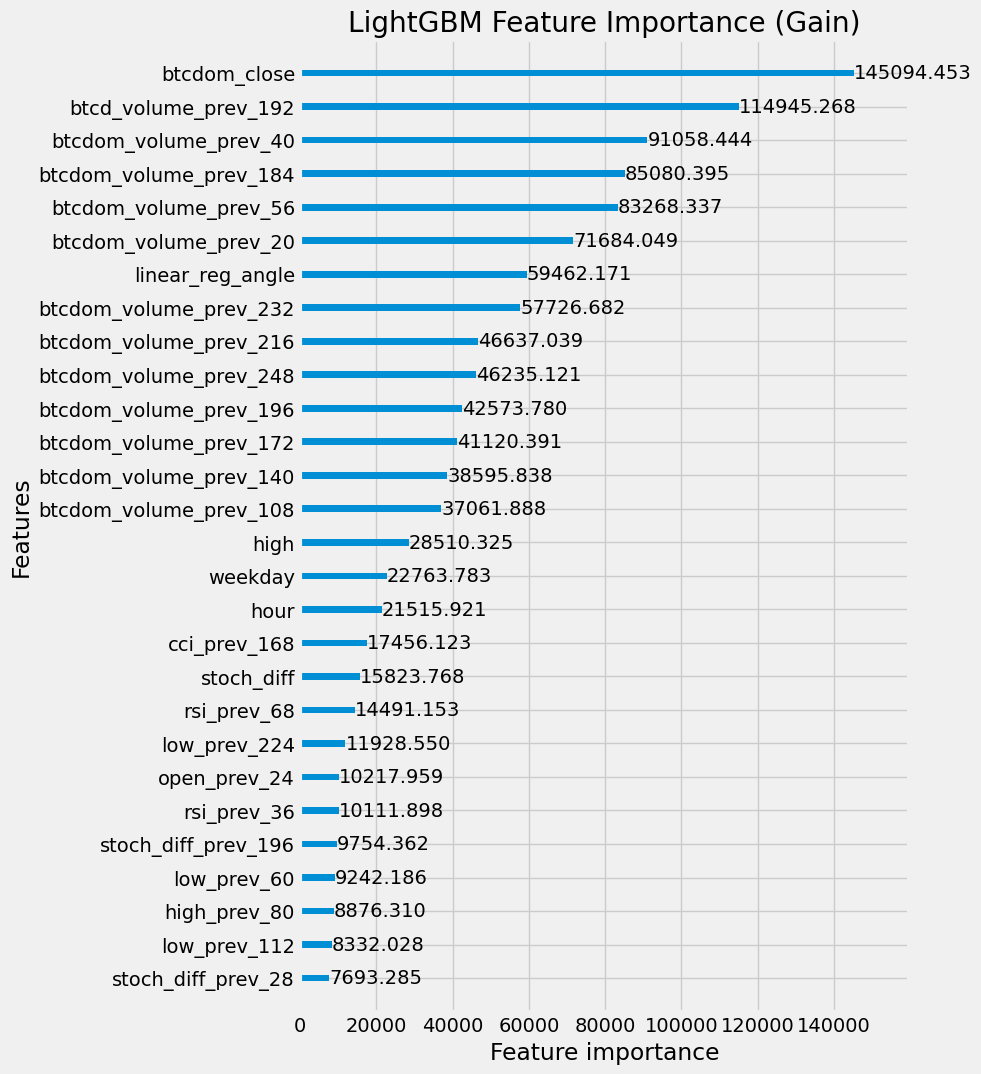

In [36]:
lgb.plot_importance(model, importance_type="gain", figsize=(7, 12), title="LightGBM Feature Importance (Gain)")
plt.show()

### Plot rolling mean ppv_npv_acc score of the model predictions for the new data

In [37]:
if not CFG.optimize:
    figsize = (12, 5)
    plt.figure(figsize=figsize)

    tmp = res[res["target"] == 1]
    
    if len(tmp) > 0:
        tmp["ppv_npv_acc"] = tmp["target"].rolling(len(tmp), min_periods=1).count() / (tmp.index + 1)

        ax = sns.lineplot(x=tmp["time"], y=tmp["ppv_npv_acc"].values)
        ax.lines[0].set_linewidth(2)
        plt.xticks(rotation=45);

<Figure size 1200x500 with 0 Axes>

# Compare indicator / signal values for bot and optimizer

In [38]:
# import pandas as pd
# from signals.find_signal import SignalFactory

# ttype = "sell"
# ticker = "BADGERUSDT"
# month = 7
# day = 15
# hour = 23
# configs = ConfigFactory.factory(environ).configs

# x = pd.read_csv(f"../bot/ticker_dataframes/{ticker}_1h_{ttype}_{month}_{day}_{hour}.csv").drop(columns=["Unnamed: 0"]).reset_index(drop=True)
# y = pd.read_csv(f"../bot/ticker_dataframes/{ticker}_4h_{ttype}_{month}_{day}_{hour}.csv").drop(columns=["Unnamed: 0"]).reset_index(drop=True)

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# x = vol24.get_indicator(x, "", "1h", 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# x = pattern.get_indicator(x, "", "", 0)
# # add trend
# trend = indicators.Trend(ttype, configs)
# y = trend.get_indicator(y, "", "", 0)

# # cols = ["time", "open", "high", "low", "close", "volume", "rsi", "stoch_slowk", "stoch_slowd", "linear_reg", "linear_reg_angle", "macd", "macdsignal", "macdhist"]
# cols = ["time", "open", "high", "low", "close", "volume", "linear_reg", "linear_reg_angle", "high_max", "low_min", "volume_24"]

# higher_features = ["time_4h", "linear_reg", "linear_reg_angle", "macd", "macdhist",  "macd_dir", 
#                    "macdsignal", "macdsignal_dir"]
# x["time"] = pd.to_datetime(x["time"])
# y["time"] = pd.to_datetime(y["time"])
# y["time_4h"] = y["time"] + pd.to_timedelta(3, unit="h")
# x[["time"] + higher_features] = pd.merge(x[["time"]], y[higher_features], how="left", left_on="time", right_on="time_4h")

# # x = x.drop(columns=["time_4h"])
# # y = y.drop(columns=["time_4h"])
# x = x.ffill()
# x = x.reset_index(drop=True)

# # get Swing pattern
# pattern = SignalFactory().factory("Pattern", ttype, configs)
# pattern_points = pattern.find_signal(x)
# trend = SignalFactory().factory("Trend", ttype, configs)
# trend_points = trend.find_signal(x)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(x.loc[idxs[0], cols])

# z = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_1h.pkl")
# v = pd.read_pickle(f"../optimizer/ticker_dataframes/{ticker}_4h.pkl")

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# z = vol24.get_indicator(z, "", "1h", 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# z = pattern.get_indicator(z, "", "", 0)
# # add Trend
# trend = indicators.Trend(ttype, configs)
# v = trend.get_indicator(v, "", "", 0)
# z.tail(48)

# v["time_4h"] = v["time"] + pd.to_timedelta(3, unit="h")
# z[["time"] + higher_features] = pd.merge(z[["time"]], y[higher_features], how="left", left_on="time", right_on="time_4h")

# z = z.drop(columns=["time_4h"])
# v = v.drop(columns=["time_4h"])
# z = z.ffill()
# z = z.reset_index(drop=True)

# # get Swing pattern
# pattern = SignalFactory().factory("Pattern", ttype, configs)
# pattern_points = pattern.find_signal(z)
# trend = SignalFactory().factory("Trend", ttype, configs)
# trend_points = trend.find_signal(z)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(z.loc[idxs[0], cols])